# Data Preprocess 1

This journal describes how to prepare the data to run the RELOG scenarios. He we will cover:
1. Waste files generation. Correlates latitude and longitude with a region and state. Takes PV ICE-generated data file and creates individual waste files based on the type of waste.
2. Make initial amounts file. Using the previously generated files, we show how to make an 'Initial amounts file' so it is in RELOG input data format. 
3. Make recycling candidates files. Generate the PV recycling plant candidates files using the correct area cost factor.
4. Continue to RELOG case-builder.
5. Make a sankey diagram from section 1.
6. Render a cloropeth map from section 2 (not finished!)

A continuation of this journal can be found in [Data Preprocess 2](./data_preprocess_2.ipynb).

***NOTE:** All quantities are given in **metric tonnes**.*

## 0. Load necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from pathlib import Path

from geopy.geocoders import Nominatim
from geopy.point import Point
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

---
## 1. Waste files generation

### 1.1. Get the GIS locations from the latitude and longitude

Load the GIS file.

In [2]:
GIS = pd.read_excel('Geo_data/gis_centroid_n.xlsx') # Read the GIS excel file.
GIS # Prints first five rows.

,long,lat,id,country
0,-121.452252,47.820991,p1,USA
1,-117.159039,35.120104,p10,USA
2,-78.257714,38.791108,p100,USA
3,-82.192477,28.708695,p101,USA
4,-80.563731,26.677092,p102,USA
...,...,...,...,...
200,-116.933572,32.485742,p201,MEX
201,-116.345053,31.558623,p202,MEX
202,-115.418298,32.607552,p203,MEX
203,-114.836778,32.379719,p204,MEX


The generated file has four columns, with longitude, latitude PCA id and country. This does not tell us much about their actual location so we can use the following gunction to create additional columns to the GIS file with the actual location names.

In [3]:
def city_state_country(row):
    # I map latitude and longitude with actual names of those places.
    coord = f"{row['lat']}, {row['long']}"
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    city = address.get('city', '')
    county = address.get('county', '')
    state = address.get('state', '')
    country = address.get('country', '')
    county_state = address.get('county', 'state')
    #row['city'] = city
    row['county'] = county
    row['state'] = state
    row['country'] = country
    #row['location'] = county_state
    return row

Generate a GIS file with the name of the locations, this will be useful for section 2, 3 and 4. Where the location names matter to assign area cost factors and to locate waste in a map. I would recommend running this function once, saving the output, and then, when needed, just read the generated csv.

#### 1.1.1 Generaye GIS file — ONLY RUN ONCE! Skip to section 1.1.2. if you already generated the file

In [4]:
%%time
# This one takes around two minutes. Apply the previous function to obtain the names of the locations.
GIS = GIS.apply(city_state_country, axis=1)
GIS.head()

CPU times: user 1.75 s, sys: 160 ms, total: 1.91 s
Wall time: 1min 42s


,long,lat,id,country,county,state
0,-121.452252,47.820991,p1,United States,Snohomish County,Washington
1,-117.159039,35.120104,p10,United States,,California
2,-78.257714,38.791108,p100,United States,Warren County,Virginia
3,-82.192477,28.708695,p101,United States,Sumter County,Florida
4,-80.563731,26.677092,p102,United States,Palm Beach County,Florida


There is one county in California that shows empty. Let's add the corresponding county. Doing a quick maps  search, I saw that the [35.120104, -117.159039](https://www.google.com/maps/place/35%C2%B007'12.4%22N+117%C2%B009'32.5%22W/@35.6668582,-117.0465162,8.1z/data=!4m5!3m4!1s0x0:0xf02b1d027b57f1cb!8m2!3d35.120104!4d-117.159039) overlaps with [San Bernardino County](https://www.google.com/maps/place/San+Bernardino+County,+CA/@34.9743906,-117.1874339,10.12z/data=!4m5!3m4!1s0x80c52a8ae8311be5:0xa438bdbc918edca!8m2!3d34.9592083!4d-116.419389). The are in [33.031747, -116.717606](https://www.google.com/maps/place/33%C2%B001'54.3%22N+116%C2%B043'03.4%22W/@33.0171076,-116.9113049,9.82z/data=!4m5!3m4!1s0x0:0xb56a6fffc57eaadd!8m2!3d33.031747!4d-116.717606) corresponds to [San Diego County](https://www.google.com/maps/place/San+Diego+County,+CA/@33.016828,-117.4064529,9z/data=!3m1!4b1!4m5!3m4!1s0x80dbeb3023ff601d:0x350dfd2beb800728!8m2!3d33.0933809!4d-116.6081653). Let's add thesevalues to the empty county fields.

In [5]:
GIS[(GIS.county == '') & (GIS.country == 'United States')] # Select the rows we need.

,long,lat,id,country,county,state
1,-117.159039,35.120104,p10,United States,,California


Now let's use the `id` column to spot the right item and add the corresponding counties.

In [6]:
GIS.loc[GIS.id == 'p10', 'county'] = 'San Bernardino'
GIS.loc[GIS.id == 'p11', 'county'] = 'San Diego'

In [7]:
GIS.head()

,long,lat,id,country,county,state
0,-121.452252,47.820991,p1,United States,Snohomish County,Washington
1,-117.159039,35.120104,p10,United States,San Bernardino,California
2,-78.257714,38.791108,p100,United States,Warren County,Virginia
3,-82.192477,28.708695,p101,United States,Sumter County,Florida
4,-80.563731,26.677092,p102,United States,Palm Beach County,Florida


Let's now save the file, so we don't have to do this ever again. Hooray!

In [8]:
GIS.to_csv('Geo_data/gis_region_names.csv')

#### 1.1.2. Load GIS file — RUN THIS ONE IF YOU ALREADY GENERATED THIS FILE

Run this cell if you already generated the `gis_region_names.csv` file.

We no filter the GIS data so there's only USA.

In [9]:
GIS = pd.read_csv('Geo_data/gis_region_names.csv')
GIS_us = GIS[GIS.country == 'United States']
GIS_us.reset_index(inplace=True)
GIS_us = GIS_us.iloc[0:134]
GIS_us.to_csv('Geo_data/GIS_us_collection_centers_only.csv')

Now that we have the data we need, I am going to separate the `long` and `lat`, and the `id` into their own dataframes for easier handling.

In [10]:
GIS_us_long_lat = GIS_us[['long', 'lat']]
GIS_us_id = GIS_us[['id']]

### 1.2. Correlate GIS longitude and latitude with FIPS codes for the map diagram and EJ API queries

This is more GIS data pre processing, it is not needed to get the waste files but will be helpful to obtain a cloropeth map with the waste, and the dataframe that with the Energy Justice metrics.

#### 1.2.1. Obtain GIS data with FIPS codes

In [11]:
fips_county_codes = []
fips_state_codes = []

**NOTE:** Run only once and skip to section 1.2.2, to just load this data.

In [12]:
%%time
# Code from https://gis.stackexchange.com/questions/294641/python-code-for-transforming-lat-long-into-fips-codes
import requests
import urllib

#Encode parameters 
for lon, lat in GIS_us_long_lat.itertuples(index=False):
    params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json'})
    #Contruct request URL
    url = 'https://geo.fcc.gov/api/census/block/find?' + params

    #Get response from API
    response = requests.get(url)

    #Parse json in response
    data = response.json()
    fips_county_codes.append(data['County']['FIPS'])
    fips_state_codes.append(data['State']['FIPS'])
    #Print FIPS code


CPU times: user 4.28 s, sys: 403 ms, total: 4.69 s
Wall time: 30.1 s


In [13]:
GIS_us_long_lat.loc[:, 'fips_county'] = fips_county_codes
GIS_us_long_lat.loc[:, 'fips_state'] = fips_state_codes

/var/folders/w2/85_h_nyn0mlbxf81x3k9n53xh90n_1/T/ipykernel_81816/4213513012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GIS_us_long_lat.loc[:, 'fips_county'] = fips_county_codes
/var/folders/w2/85_h_nyn0mlbxf81x3k9n53xh90n_1/T/ipykernel_81816/4213513012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GIS_us_long_lat.loc[:, 'fips_state'] = fips_state_codes


In [14]:
GIS_us_long_lat.head()

,long,lat,fips_county,fips_state
0,-121.452252,47.820991,53061,53
1,-117.159039,35.120104,06071,06
2,-78.257714,38.791108,51187,51
3,-82.192477,28.708695,12119,12
4,-80.563731,26.677092,12099,12


In [15]:
GIS_us_long_lat.to_csv('Geo_data/GIS_us_long_lat.csv') # Save file

#### 1.2.2. Load GIS with FIPS data

In [16]:
GIS_us_long_lat = pd.read_csv('Geo_data/GIS_us_long_lat.csv') # Load file

### 1.3. Separate the PV ICE output and create individual material file

Here I create a path to the folder where we saved the waste files generated by PV ICE inside the TEMP folder or `RICE/1_PV_ICE_waste_calculations/TEMP`. As of Mon Feb 20, 2023, there are three folders in `TEMP`:

* `PCAs_RELOG_Method1`: Method 1 uses the raw ReEDS data with the unrealistic deployment schedules. This creates uneven peaks of waste.
* `PCAs_RELOG_Method2`: Method 2 uses ordered ReEDS data which orders wastes between 2021 to 2035 and 2046 to 2050. Still creates unrealistic peaks.
* `PCAs_RELOG_Method3`: Uses the cummulative capacity between 2021 to 2035 and 2034 to 2050 to create a logarithmic growth of waste (this method is being tested, not validated yet, and subjected to ongoing changes).
 
For the purpose of this journal we will be looking at the `PCAs_RELOG_Method3` folder which is presumably a more realistic deployment scenario. 

#### 1.3.1. Set up the working folders

This is a list of all the possible scenarios that we can select.

In [17]:
pv_ice_simulations = ['Method1', 'Method2','Method3']
print("Choose one of the following methods: Method1, Method2 or Method3.")
pv_ice_simulations = None
while pv_ice_simulations not in {"Method1", "Method2", "Method3"}:
    pv_ice_simulations = input('Input method not in the list, please choose one of the following methods: Method1, Method2 or Method3.')
print('You have chosen {}.'.format(pv_ice_simulations))

Choose one of the following methods: Method1, Method2 or Method3.


Input method not in the list, please choose one of the following methods: Method1, Method2 or Method3. Method1


You have chosen Method1.


In [18]:
previous_folder = os.path.normpath(os.getcwd() + os.sep + os.pardir) # Get previous folder from current directory
pvice_TEMP_folder = os.path.join(previous_folder, '1_PV_ICE_waste_calculations','TEMP') # Change the number for the scenario you want to run

Check if the path exists, if not, it will create the path with necessary folders.

This is to make the output file.

In [19]:
cwd = os.getcwd()
pvice_output_folder = os.path.join(cwd, 'PV_ICE_clean_outputs','Recycling', pv_ice_simulations)

In [20]:
#python program to check if a directory exists
import os

# Check whether the specified path exists or not
isExist = os.path.exists(pvice_output_folder)
if isExist:
    print("The path already exists!")
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(pvice_output_folder)
   print("The new directory has been created!")

The new directory has been created!


Read the cSi and CdTe waste files, respectively.

In [21]:
pvice_output_folder


'/Users/mmendez/Documents/Postdoc/Software_dev/RICE/2_data_preparation/PV_ICE_clean_outputs/Recycling/Method1'

In [22]:
csi_eol = pd.read_csv(os.path.join(pvice_TEMP_folder, f'PVICE_RELOG_PCA_cSi_WasteEOL_{pv_ice_simulations}.csv'), index_col='year')
cdte_eol = pd.read_csv(os.path.join(pvice_TEMP_folder, f'PVICE_RELOG_PCA_CdTe_WasteEOL_{pv_ice_simulations}.csv'), index_col='year')

In [23]:
print('We have %s collection centers.' % len(GIS_us))

We have 134 collection centers.


Now I need to select the columns and separate them by material, then add a column identifying the locations. Ideally, I need to populate a table for each material.

In [24]:
material_list_csi = ['glass', 'silicon', 'silver', 'copper', 'aluminium_frames', 'encapsulant', 'backsheet', 'Module']
material_list_cdte = ['cadmium', 'tellurium', 'glass_cdte', 'aluminium_frames_cdte', 'Module', 'copper_cdte', 'encapsulant_cdte']

In [25]:
nums = np.arange(1,42)
years = np.arange(2010,2051)
years_dict = {nums[i]: years[i] for i in range(len(nums))}

In [26]:
mats = ['csi', 'cdte']

#### 1.3.2. Generate waste files separated by technology and material.

In [27]:
for y in mats:
    if y == 'csi':
        for x in material_list_csi:
            globals()['%s_%s_sel' % (y, x)] = [col for col in globals()['%s_eol' % y].columns if x in col]
            globals()['%s_%s' % (y, x)] = csi_eol.filter(globals()['%s_%s_sel' % (y, x)], axis=1)
            globals()['%s_%s' % (y, x)] = globals()['%s_%s' % (y, x)].transpose()
            globals()['%s_%s' % (y, x)].reset_index(inplace=True)
            globals()['%s_%s' % (y, x)] = pd.concat([globals()['%s_%s' % (y, x)], GIS_us_long_lat], axis=1, ignore_index=True)
            globals()['%s_%s' % (y, x)].rename(columns = years_dict, inplace=True)
           # globals()['%s_%s' % (y, x)].rename(columns = {42:'PCA area'}, inplace=True)
            globals()['%s_%s' % (y, x)].rename(columns = {42:'longitude', 43:'latitude', 44:'FIPS'}, inplace=True)
            globals()['%s_%s' % (y, x)]['total waste'] = globals()['%s_%s' % (y, x)].loc[:, 2010:2050].sum(axis=1)
            globals()['%s_%s' % (y, x)].to_csv(os.path.join(pvice_output_folder, '{}_wasteEOL_{}.csv'.format(y, x)), index=False)
    elif y == 'cdte':
        for x in material_list_cdte:
            globals()['%s_%s_sel' % (y, x)] = [col for col in globals()['%s_eol' % y].columns if x in col]
            globals()['%s_%s' % (y, x)] = cdte_eol.filter(globals()['%s_%s_sel' % (y, x)], axis=1)
            globals()['%s_%s' % (y, x)] = globals()['%s_%s' % (y, x)].transpose()
            globals()['%s_%s' % (y, x)].reset_index(inplace=True)
            globals()['%s_%s' % (y, x)] = pd.concat([globals()['%s_%s' % (y, x)], GIS_us_long_lat], axis=1, ignore_index=True)
            globals()['%s_%s' % (y, x)].rename(columns = years_dict, inplace=True)
           # globals()['%s_%s' % (y, x)].rename(columns = {42:'PCA area'}, inplace=True)
            globals()['%s_%s' % (y, x)].rename(columns = {42:'longitude', 43:'latitude', 44:'FIPS'}, inplace=True)
            globals()['%s_%s' % (y, x)]['total waste'] = globals()['%s_%s' % (y, x)].loc[:, 2010:2050].sum(axis=1)
            globals()['%s_%s' % (y, x)].to_csv(os.path.join(pvice_output_folder, '{}_wasteEOL_{}.csv'.format(y, x)), index=False)
            
            

## 2. Initial amounts file generation

Here I will be generating the file that has the waste initial amounts according to RELOG's template (Initial amounts - Template.csv).
![image.png](images/Initial_amounts_temp.png)

I have two options:
1) Add at the wastes and then do the processing to create ONE template of initial amounts.
2) Create THREE templates, two with CdTe and cSi separated, and then create another one summing the previous two.

I am going to do option 2, that way if we decide to generate a separate RELOG scenario with one or the other technology, we have already separate files. I am also  going to create the files for individual materials in case they update the software so we also have material timeseries.

**IMPORTANT:** I need to make unique names for this file, so I will add the state next to the county.

### 2.1. Load the waste files that we just generated.

**LOAD OPTION 1:** If you have run Section 1.3.2 cells, fetch the data as csi_Module and cdte_Module. I make a copy of these files since I will be changing them considerably. To use this option set the following cell to `load = False`.

**LOAD OPTION 2:** If you haven't run Section 1.3.2 cells, use function load_csv with the corresponding file name. To use this option set the following cell to `load = True`.

In [28]:
load = False #If you have not run Section 1 cells

In [29]:
if load == True:
    csi_Module_ia = pd.read_csv(os.path.join(pvice_output_folder,'csi_wasteEOL_Module.csv'))
    csi_glass_ia = pd.read_csv(os.path.join(pvice_output_folder,'csi_wasteEOL_glass.csv'))
    csi_silicon_ia = pd.read_csv(os.path.join(pvice_output_folder,'csi_wasteEOL_silicon.csv'))
    csi_silver_ia = pd.read_csv(os.path.join(pvice_output_folder,'csi_wasteEOL_silver.csv'))
    csi_copper_ia = pd.read_csv(os.path.join(pvice_output_folder,'csi_wasteEOL_copper.csv'))
    csi_aluminium_frames_ia = pd.read_csv(os.path.join(pvice_output_folder,'csi_wasteEOL_aluminium_frames.csv'))
    csi_encapsulant_ia = pd.read_csv(os.path.join(pvice_output_folder,'csi_wasteEOL_encapsulant.csv'))
    csi_backsheet_ia = pd.read_csv(os.path.join(pvice_output_folder,'csi_wasteEOL_backsheet.csv'))

    cdte_Module_ia = pd.read_csv(os.path.join(pvice_output_folder,'cdte_wasteEOL_Module.csv'))
    cdte_cadmium_ia = pd.read_csv(os.path.join(pvice_output_folder,'cdte_wasteEOL_cadmium.csv'))
    cdte_tellurium_ia = pd.read_csv(os.path.join(pvice_output_folder,'cdte_wasteEOL_tellurium.csv'))
    cdte_glass_cdte_ia = pd.read_csv(os.path.join(pvice_output_folder,'cdte_wasteEOL_glass_cdte.csv'))
    cdte_aluminium_frames_cdte_ia = pd.read_csv(os.path.join(pvice_output_folder,'cdte_wasteEOL_aluminium_frames_cdte.csv'))
    cdte_copper_cdte_ia = pd.read_csv(os.path.join(pvice_output_folder,'cdte_wasteEOL_copper_cdte.csv'))
    cdte_encapsulant_cdte_ia = pd.read_csv(os.path.join(pvice_output_folder,'cdte_wasteEOL_encapsulant_cdte.csv'))
else:    
    csi_Module_ia = csi_Module.copy()
    csi_glass_ia = csi_glass.copy()
    csi_silicon_ia = csi_silicon.copy()
    csi_silver_ia = csi_silver.copy()
    csi_copper_ia = csi_copper.copy()
    csi_aluminium_frames_ia = csi_aluminium_frames.copy()
    csi_encapsulant_ia = csi_encapsulant.copy()
    csi_backsheet_ia = csi_backsheet.copy()


    cdte_Module_ia = cdte_Module.copy()
    cdte_cadmium_ia = cdte_cadmium.copy()
    cdte_tellurium_ia = cdte_tellurium.copy()
    cdte_glass_cdte_ia = cdte_glass_cdte.copy()
    cdte_aluminium_frames_cdte_ia = cdte_aluminium_frames_cdte.copy()
    cdte_copper_cdte_ia = cdte_copper_cdte.copy()
    cdte_encapsulant_cdte_ia = cdte_encapsulant_cdte.copy()

# 'ia' stands for initial amounts

### 2.2. Drop unnecessary columns

Drop columns: 0, 2010 (there is no waste here), FIPS, 45, longitude, latitude and total waste columns. Then I insert the 'name' row and then move longitude and latitude rows

In [37]:
columns_to_erase = [0, 2010, 'FIPS', 45, 46, 'total waste', 'latitude', 'longitude']

In [38]:
csi_Module_ia

,0,2010,2011,2012,2013,2014,2015,2016,2017,2018,...,2047,2048,2049,2050,longitude,latitude,FIPS,45,46,total waste
0,WasteEOL_Module_95-by-35_Elec.Adv_DR_cSi_p1_[T...,0.0,4.948422e-10,2.069742e-07,0.000016,2.249295e-04,1.468333e-03,6.213866e-03,0.019958,0.053102,...,883.058388,1135.052166,1692.986270,1757.063044,0,-121.452252,47.820991,53061,53,12780.128618
1,WasteEOL_Module_95-by-35_Elec.Adv_DR_cSi_p10_[...,0.0,1.556206e-05,1.488771e-03,0.021089,1.364295e-01,5.761897e-01,1.860835e+00,5.003013,11.787674,...,23218.932466,26321.994974,47710.808172,26314.989085,1,-117.159039,35.120104,6071,6,960116.113540
2,WasteEOL_Module_95-by-35_Elec.Adv_DR_cSi_p100_...,0.0,0.000000e+00,0.000000e+00,0.000000,2.748921e-10,4.344422e-08,8.294458e-07,0.000007,0.000034,...,73.418509,81.722579,203.290647,64.428824,2,-78.257714,38.791108,51187,51,1340.440564
3,WasteEOL_Module_95-by-35_Elec.Adv_DR_cSi_p101_...,0.0,7.622608e-07,7.315401e-05,0.001055,7.001720e-03,3.030288e-02,9.970088e-02,0.270894,0.639871,...,12184.265965,13694.472710,21012.251037,14305.015750,3,-82.192477,28.708695,12119,12,167542.044366
4,WasteEOL_Module_95-by-35_Elec.Adv_DR_cSi_p102_...,0.0,5.264830e-07,5.015102e-05,0.000693,4.317194e-03,1.752123e-02,5.441984e-02,0.140788,0.318981,...,8566.612883,10823.397007,16397.861116,15823.624399,4,-80.563731,26.677092,12099,12,94415.941667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,WasteEOL_Module_95-by-35_Elec.Adv_DR_cSi_p95_[...,0.0,0.000000e+00,0.000000e+00,0.000000,2.997283e-10,4.736936e-08,9.140153e-07,0.000009,0.000066,...,11721.268664,15982.385290,21830.654631,28171.504747,129,-82.058502,34.683402,45059,45,107292.403489
130,WasteEOL_Module_95-by-35_Elec.Adv_DR_cSi_p96_[...,0.0,0.000000e+00,0.000000e+00,0.000000,2.367906e-09,3.742262e-07,7.170544e-06,0.000062,0.000371,...,10495.253778,12114.923755,17120.467070,14268.252211,130,-80.470185,33.666562,45027,45,113453.006717
131,WasteEOL_Module_95-by-35_Elec.Adv_DR_cSi_p97_[...,0.0,2.812159e-07,2.768002e-05,0.000456,3.539070e-03,1.746759e-02,6.353884e-02,0.186430,0.468116,...,2422.822614,2622.337507,5439.269964,1985.448754,131,-81.469485,35.703545,37023,37,71794.703182
132,WasteEOL_Module_95-by-35_Elec.Adv_DR_cSi_p98_[...,0.0,7.611838e-08,9.273211e-06,0.000294,3.419133e-03,2.094443e-02,8.662297e-02,0.277530,0.747065,...,7373.704440,7720.296593,18309.836071,4130.873906,132,-78.063174,35.438992,37191,37,270215.469198


In [39]:
csi_Module_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
csi_glass_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
csi_silicon_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
csi_silver_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
csi_copper_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
csi_aluminium_frames_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
csi_encapsulant_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
csi_backsheet_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.

In [40]:
cdte_Module_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
cdte_cadmium_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
cdte_tellurium_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
cdte_glass_cdte_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.)
cdte_aluminium_frames_cdte_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
cdte_copper_cdte_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.
cdte_encapsulant_cdte_ia.drop(columns_to_erase, axis=1, inplace= True) # Run this one only once or it will throw an error.

In [43]:
csi_Module_ia.head()

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,4.948422e-10,2.069742e-07,0.000016,2.249295e-04,1.468333e-03,6.213866e-03,0.019958,0.053102,0.123433,0.259441,...,349.284170,441.575556,1109.313006,1071.918119,617.189727,1239.784957,883.058388,1135.052166,1692.986270,1757.063044
1,1.556206e-05,1.488771e-03,0.021089,1.364295e-01,5.761897e-01,1.860835e+00,5.003013,11.787674,25.162912,49.776116,...,33090.492842,39411.840316,134403.711249,114393.756346,24275.829297,62044.985048,23218.932466,26321.994974,47710.808172,26314.989085
2,0.000000e+00,0.000000e+00,0.000000,2.748921e-10,4.344422e-08,8.294458e-07,0.000007,0.000034,0.000131,0.000433,...,53.107466,65.733444,91.976735,101.969659,101.205707,322.612322,73.418509,81.722579,203.290647,64.428824
3,7.622608e-07,7.315401e-05,0.001055,7.001720e-03,3.030288e-02,9.970088e-02,0.270894,0.639871,1.360242,2.667169,...,6380.247402,7961.962995,15431.300597,15610.886879,11332.766441,24193.545977,12184.265965,13694.472710,21012.251037,14305.015750
4,5.264830e-07,5.015102e-05,0.000693,4.317194e-03,1.752123e-02,5.441984e-02,0.140788,0.318981,0.653680,1.238906,...,2312.667543,3058.998998,4313.948820,5337.212786,6319.798983,13246.682204,8566.612883,10823.397007,16397.861116,15823.624399


### 2.3. Add the name locations, latitude and longitude with the right names to the right position.

I take the location file from GIS.

In [44]:
GIS_usa = GIS[GIS.country == 'United States']
GIS_usa.reset_index(inplace=True)
GIS_usa = GIS_usa.iloc[0:134] # I slice it until 142 because the next locations are not in ReEDS.

This line makes a new column with County, State so I make unique names for the RELOG "Initial Amounts" input file.

In [45]:
GIS_usa['name'] = GIS_usa['county'] + ', ' + GIS_usa['state']

In [46]:
len(GIS_usa['name'].unique()) 

134

In [47]:
csi_Module_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
csi_Module_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
csi_Module_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

csi_glass_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
csi_glass_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
csi_glass_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

csi_silicon_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
csi_silicon_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
csi_silicon_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

csi_silver_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
csi_silver_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
csi_silver_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

csi_copper_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
csi_copper_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
csi_copper_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

csi_aluminium_frames_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
csi_aluminium_frames_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
csi_aluminium_frames_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

csi_encapsulant_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
csi_encapsulant_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
csi_encapsulant_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

csi_backsheet_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
csi_backsheet_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
csi_backsheet_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

In [48]:
cdte_Module_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
cdte_Module_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
cdte_Module_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

cdte_cadmium_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
cdte_cadmium_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
cdte_cadmium_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

cdte_tellurium_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
cdte_tellurium_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
cdte_tellurium_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

cdte_glass_cdte_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
cdte_glass_cdte_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
cdte_glass_cdte_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

cdte_aluminium_frames_cdte_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
cdte_aluminium_frames_cdte_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
cdte_aluminium_frames_cdte_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

cdte_copper_cdte_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
cdte_copper_cdte_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
cdte_copper_cdte_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

cdte_encapsulant_cdte_ia.insert(0, 'name', GIS_usa[['name']]) # Run this one only once or it will throw an error.
cdte_encapsulant_cdte_ia.insert(1, 'latitude (deg)', GIS_usa[['lat']]) 
cdte_encapsulant_cdte_ia.insert(2, 'longitude (deg)', GIS_usa[['long']]) 

#### 2.3.1 Add accumulated waste until year 2025

Since I am studying from 2025 onward with RELOG (because there is no significant amount of waste for RELOG to process in the recycling plants), I add the waste generated from 2011 until 2023. 

In [51]:
csi_Module_ia_sumyears = csi_Module_ia.loc[:, 2011:2025].sum(axis=1)
csi_glass_ia_sumyears = csi_glass_ia.loc[:, 2011:2025].sum(axis=1)
csi_silicon_ia_sumyears = csi_silicon_ia.loc[:, 2011:2025].sum(axis=1)
csi_silver_ia_sumyears = csi_silver_ia.loc[:, 2011:2025].sum(axis=1)
csi_copper_ia_sumyears = csi_copper_ia.loc[:, 2011:2025].sum(axis=1)
csi_aluminium_frames_ia_sumyears = csi_aluminium_frames_ia.loc[:, 2011:2025].sum(axis=1)
csi_encapsulant_ia_sumyears = csi_encapsulant_ia.loc[:, 2011:2025].sum(axis=1)
csi_backsheet_ia_sumyears = csi_backsheet_ia.loc[:, 2011:2025].sum(axis=1)


cdte_Module_ia_sumyears = cdte_Module_ia.loc[:, 2011:2025].sum(axis=1)
cdte_cadmium_ia_sumyears = cdte_cadmium_ia.loc[:, 2011:2025].sum(axis=1)
cdte_tellurium_ia_sumyears = cdte_tellurium_ia.loc[:, 2011:2025].sum(axis=1)
cdte_glass_cdte_ia_sumyears = cdte_glass_cdte_ia.loc[:, 2011:2025].sum(axis=1)
cdte_aluminium_frames_cdte_ia_sumyears = cdte_aluminium_frames_cdte_ia.loc[:, 2011:2025].sum(axis=1)
cdte_copper_cdte_ia_sumyears = cdte_copper_cdte_ia.loc[:, 2011:2025].sum(axis=1)
cdte_encapsulant_cdte_ia_sumyears = cdte_encapsulant_cdte_ia.loc[:, 2011:2025].sum(axis=1)

Drop columns 2011 to 2025.

In [52]:
csi_Module_ia.drop(csi_Module_ia.loc[:, 2011:2025], inplace=True, axis=1)
csi_glass_ia.drop(csi_glass_ia.loc[:, 2011:2025], inplace=True, axis=1)
csi_silicon_ia.drop(csi_silicon_ia.loc[:, 2011:2025], inplace=True, axis=1)
csi_silver_ia.drop(csi_silver_ia.loc[:, 2011:2025], inplace=True, axis=1)
csi_copper_ia.drop(csi_copper_ia.loc[:, 2011:2025], inplace=True, axis=1)
csi_aluminium_frames_ia.drop(csi_aluminium_frames_ia.loc[:, 2011:2025], inplace=True, axis=1)
csi_encapsulant_ia.drop(csi_encapsulant_ia.loc[:, 2011:2025], inplace=True, axis=1)
csi_backsheet_ia.drop(csi_backsheet_ia.loc[:, 2011:2025], inplace=True, axis=1)

cdte_Module_ia.drop(cdte_Module_ia.loc[:, 2011:2025], inplace=True, axis=1)
cdte_cadmium_ia.drop(cdte_cadmium_ia.loc[:, 2011:2025], inplace=True, axis=1)
cdte_tellurium_ia.drop(cdte_tellurium_ia.loc[:, 2011:2025], inplace=True, axis=1)
cdte_glass_cdte_ia.drop(cdte_glass_cdte_ia.loc[:, 2011:2025], inplace=True, axis=1)
cdte_aluminium_frames_cdte_ia.drop(cdte_aluminium_frames_cdte_ia.loc[:, 2011:2025], inplace=True, axis=1)
cdte_copper_cdte_ia.drop(cdte_copper_cdte_ia.loc[:, 2011:2025], inplace=True, axis=1)
cdte_encapsulant_cdte_ia.drop(cdte_encapsulant_cdte_ia.loc[:, 2011:2025], inplace=True, axis=1)

In [53]:
cdte_Module_ia.head()

,name,latitude (deg),longitude (deg),2026,2027,2028,2029,2030,2031,2032,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,"Snohomish County, Washington",47.820991,-121.452252,0.880110,1.383154,2.117192,3.162629,4.617654,6.598716,9.437634,...,58.630387,76.201919,159.187609,206.095928,127.071726,224.445098,202.092847,264.233099,378.471462,428.230352
1,"San Bernardino, California",35.120104,-117.159039,232.183221,354.557126,528.224809,768.849212,1094.585594,1525.595951,8300.663172,...,4947.318864,5955.210965,16715.558238,20961.538304,4233.293596,9341.853227,4703.435042,5464.550252,8967.357918,6209.225804
2,"Warren County, Virginia",38.791108,-78.257714,0.020700,0.039060,0.070129,0.120499,0.199162,0.318025,0.492417,...,7.701787,9.611040,13.099704,15.759162,15.411663,44.348857,13.289633,15.327466,34.336857,15.318619
3,"Sumter County, Florida",28.708695,-82.192477,9.720313,14.861420,22.356363,33.103566,48.252944,69.241422,402.373749,...,1078.831876,1364.266498,2315.648821,2879.292756,2113.667667,3906.431455,2534.568269,2900.384496,4132.766904,3306.120096
4,"Palm Beach County, Florida",26.677092,-80.563731,4.482559,6.573824,9.473635,13.435017,18.772057,25.874736,245.579139,...,417.567360,565.981120,792.224332,1043.356288,1273.995490,2321.281577,1929.256725,2475.398769,3561.299250,3796.355445


Insert the 2025 column that summed the waste between 2011 to 2025.

In [54]:
csi_Module_ia.insert(3, 2025, csi_Module_ia_sumyears)
csi_glass_ia.insert(3, 2025, csi_glass_ia_sumyears)
csi_silicon_ia.insert(3, 2025, csi_silicon_ia_sumyears)
csi_silver_ia.insert(3, 2025, csi_silver_ia_sumyears)
csi_copper_ia.insert(3, 2025, csi_copper_ia_sumyears)
csi_aluminium_frames_ia.insert(3, 2025, csi_aluminium_frames_ia_sumyears)
csi_encapsulant_ia.insert(3, 2025, csi_encapsulant_ia_sumyears)
csi_backsheet_ia.insert(3, 2025, csi_backsheet_ia_sumyears)

cdte_Module_ia.insert(3, 2025, cdte_Module_ia_sumyears) 
cdte_cadmium_ia.insert(3, 2025, cdte_cadmium_ia_sumyears) 
cdte_tellurium_ia.insert(3, 2025, cdte_tellurium_ia_sumyears) 
cdte_glass_cdte_ia.insert(3, 2025, cdte_glass_cdte_ia_sumyears) 
cdte_aluminium_frames_cdte_ia.insert(3, 2025, cdte_aluminium_frames_cdte_ia_sumyears) 
cdte_copper_cdte_ia.insert(3, 2025, cdte_copper_cdte_ia_sumyears) 
cdte_encapsulant_cdte_ia.insert(3, 2025, cdte_encapsulant_cdte_ia_sumyears) 

In [55]:
csi_Module_ia.head()

,name,latitude (deg),longitude (deg),2025,2026,2027,2028,2029,2030,2031,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,"Snohomish County, Washington",47.820991,-121.452252,10.523165,6.786649,10.337083,15.358896,22.299612,31.678396,44.072829,...,349.284170,441.575556,1109.313006,1071.918119,617.189727,1239.784957,883.058388,1135.052166,1692.986270,1757.063044
1,"San Bernardino, California",35.120104,-117.159039,1816.600206,1125.004822,1693.918257,2489.865269,3577.650205,5030.353945,6926.235235,...,33090.492842,39411.840316,134403.711249,114393.756346,24275.829297,62044.985048,23218.932466,26321.994974,47710.808172,26314.989085
2,"Warren County, Virginia",38.791108,-78.257714,0.094556,0.113560,0.221376,0.407608,0.714308,1.199150,1.938840,...,53.107466,65.733444,91.976735,101.969659,101.205707,322.612322,73.418509,81.722579,203.290647,64.428824
3,"Sumter County, Florida",28.708695,-82.192477,95.067951,59.613363,91.562341,138.157351,204.894845,298.733022,428.249163,...,6380.247402,7961.962995,15431.300597,15610.886879,11332.766441,24193.545977,12184.265965,13694.472710,21012.251037,14305.015750
4,"Palm Beach County, Florida",26.677092,-80.563731,39.177269,22.664551,33.674455,49.206003,70.786721,100.334059,140.232534,...,2312.667543,3058.998998,4313.948820,5337.212786,6319.798983,13246.682204,8566.612883,10823.397007,16397.861116,15823.624399


#### 2.3.2. Change years for amounts

Change the column names as 'amount 1', 'amount 2', etc. I am not sure if it matters, but I am going to do it just in case!
From 2023 to 2050, we have a total of 28 amounts.

In [56]:
num_years = len(csi_Module_ia.columns) - 3 # simulation years
num_years

26

In [57]:
column_names = ['name', 'latitude (deg)', 'longitude (deg)']

In [58]:
for year in range(num_years):
    amounts = f'amount {year+1}'
    column_names.append(amounts)

In [59]:
csi_Module_ia.set_axis(column_names, axis=1, inplace=True)
csi_glass_ia.set_axis(column_names, axis=1, inplace=True)
csi_silicon_ia.set_axis(column_names, axis=1, inplace=True)
csi_silver_ia.set_axis(column_names, axis=1, inplace=True)
csi_copper_ia.set_axis(column_names, axis=1, inplace=True)
csi_aluminium_frames_ia.set_axis(column_names, axis=1, inplace=True)
csi_encapsulant_ia.set_axis(column_names, axis=1, inplace=True)
csi_backsheet_ia.set_axis(column_names, axis=1, inplace=True)

cdte_Module_ia.set_axis(column_names, axis=1, inplace=True)
cdte_cadmium_ia.set_axis(column_names, axis=1, inplace=True)
cdte_tellurium_ia.set_axis(column_names, axis=1, inplace=True)
cdte_glass_cdte_ia.set_axis(column_names, axis=1, inplace=True)
cdte_aluminium_frames_cdte_ia.set_axis(column_names, axis=1, inplace=True)
cdte_copper_cdte_ia.set_axis(column_names, axis=1, inplace=True)
cdte_encapsulant_cdte_ia.set_axis(column_names, axis=1, inplace=True)


### 2.4. Create new PV datasets that add cSi and CdTe 

Here I add cSi and CdTe modules as one, and common materials as one.

In [60]:
pv_Modules_ia = pd.DataFrame(columns = column_names)
pv_glass_ia = pd.DataFrame(columns = column_names)
pv_copper_ia = pd.DataFrame(columns = column_names)
pv_aluminium_frames_ia = pd.DataFrame(columns = column_names)
pv_encapsulant_ia = pd.DataFrame(columns = column_names)


Fill the data of name, latitude and longitude.

In [61]:
pv_Modules_ia['name'], pv_Modules_ia['latitude (deg)'],pv_Modules_ia['longitude (deg)'] = csi_Module_ia[['name']], csi_Module_ia[['latitude (deg)']],csi_Module_ia[['longitude (deg)']] 
pv_glass_ia['name'], pv_glass_ia['latitude (deg)'],pv_glass_ia['longitude (deg)'] = csi_Module_ia[['name']], csi_Module_ia[['latitude (deg)']],csi_Module_ia[['longitude (deg)']] 
pv_copper_ia['name'], pv_copper_ia['latitude (deg)'],pv_copper_ia['longitude (deg)'] = csi_Module_ia[['name']], csi_Module_ia[['latitude (deg)']],csi_Module_ia[['longitude (deg)']] 
pv_aluminium_frames_ia['name'], pv_aluminium_frames_ia['latitude (deg)'],pv_aluminium_frames_ia['longitude (deg)'] = csi_Module_ia[['name']], csi_Module_ia[['latitude (deg)']],csi_Module_ia[['longitude (deg)']] 
pv_encapsulant_ia['name'], pv_encapsulant_ia['latitude (deg)'],pv_encapsulant_ia['longitude (deg)'] = csi_Module_ia[['name']], csi_Module_ia[['latitude (deg)']],csi_Module_ia[['longitude (deg)']] 

Add amounts.

In [62]:
pv_Modules_ia.iloc[:,3::] = cdte_Module_ia.iloc[:,3::] + csi_Module_ia.iloc[:,3::] 
pv_glass_ia.iloc[:,3::] = csi_glass_ia.iloc[:,3::] + cdte_glass_cdte_ia.iloc[:,3::] 
pv_copper_ia.iloc[:,33::] = csi_copper_ia.iloc[:,3::] + cdte_copper_cdte_ia.iloc[:,3::] 
pv_aluminium_frames_ia.iloc[:,3::] = csi_aluminium_frames_ia.iloc[:,3::] + cdte_aluminium_frames_cdte_ia.iloc[:,3::] 
pv_encapsulant_ia.iloc[:,3::] = csi_encapsulant_ia.iloc[:,33::] + cdte_encapsulant_cdte_ia.iloc[:,3::] 





### 2.5. Export the 'Ininital amounts' files

In [63]:
cwd = os.getcwd()
RELOG_PV_ICE_import_data = os.path.join(cwd, 'RELOG_import_data/Recycling', pv_ice_simulations)

In [64]:
#python program to check if a directory exists
import os

# Check whether the specified path exists or not
isExist = os.path.exists(RELOG_PV_ICE_import_data)
if isExist:
    print("The path already exists!")
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(RELOG_PV_ICE_import_data)
    print("The new directory is created!")

The new directory is created!


In [65]:
pv_Modules_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data, 'pv_Modules_ia.csv'), index=False)
pv_glass_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'pv_glass_ia.csv'), index=False)
pv_copper_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'pv_copper_ia.csv'), index=False)
pv_aluminium_frames_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'pv_aluminium_frames_ia.csv'), index=False)
pv_encapsulant_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'pv_encapsulant_ia.csv'), index=False)

csi_Module_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'csi_Module_ia.csv'), index=False)
csi_glass_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'csi_glass_ia.csv'), index=False)
csi_silicon_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'csi_silicon_ia.csv'), index=False)
csi_silver_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'csi_silver_ia.csv'), index=False)
csi_copper_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'csi_copper_ia.csv'), index=False)
csi_aluminium_frames_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'csi_aluminium_frames_ia.csv'), index=False)
csi_encapsulant_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'csi_encapsulant_ia.csv'), index=False)
csi_backsheet_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'csi_backsheet_ia.csv'), index=False)

cdte_Module_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'cdte_Module_ia.csv'), index=False)
cdte_cadmium_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'cdte_cadmium_ia.csv'), index=False)
cdte_tellurium_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'cdte_tellurium_ia.csv'), index=False)
cdte_glass_cdte_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'cdte_glass_cdte_ia.csv'), index=False)
cdte_aluminium_frames_cdte_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'cdte_aluminium_frames_cdte_ia.csv'), index=False)
cdte_copper_cdte_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'cdte_copper_cdte_ia.csv'), index=False)
cdte_encapsulant_cdte_ia.to_csv(os.path.join(RELOG_PV_ICE_import_data,'cdte_encapsulant_cdte_ia.csv'), index=False)


Remember that silver, silicon and backsheet are exclusively from cSi modules, likewise cadmium and tellurium are exclusive from CdTe. Further studies might not mix glass due to different compositions.

#### The Initial Amounts file I used for the baseline RELOG scenario, aka. 'CASE 0', is `pv_Modules_ia.csv`.

---
## 3. Recycling candidate file generation

RELOG requires a file with the recycling plant candidates locations. This dataframe requirtes a column with:
* Unique location names
* Longitude and latitudes
* Initial capacity (tonne)
* Area cost factors (relative to the place where the cost analysis was made).

Here I propose three approaches:
1. File with DOD Area cost factors (based on the most recent Nwike's battery paper) — see Section 3.1. 
2. File creation using **PLANT DESIGN AND ECONOMICS FOR CHEMICAL ENGINEERS, Peter M. S.** area cost factors. — see Section 3.2. Here I give two versions:
    - Version 1: When we have the state in the column name.
    - Version 2: When we don't have the state defined in the name.
3. Create an empty template — see section 3.3.
4. Candidate locations based on the IGate Manufacturing locations.
5. Candidate locations based on BIL 40209, energy communities from retired plants.
**NOTE:** Most of the original candidate location files are in a local file not available to the public. To access this data contact the repository authors.

In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from pathlib import Path
import random
import re
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.point import Point
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

### 3.1. DOD Nwike's cost indices

Nwike's paper uses the [DOD](https://www.usace.army.mil/Cost-Engineering/Area-Cost-Factors/) area cost factors to set up the location-based costs, with the following Candidate Locations file: file 'Candidate locations - Battery Project' found in the shared Box.

These numbers seem more updated, and mine are from the 90's there might be caveats. So I will consider using these instead. For this, I need to:

1. Upload the "Candidate Locations - Battery" file. 
2. Since this file does not contain state, it might be useful to change the `name` column as "nwike's name, city, county, state name". This is not strictly necessary though, it is just helpful to use for better user experience so the user knows which county belongs to which state.
3. Change the area cost factors to the area we are basing our plant cost model. This might be a bit tricky because the cost factors are not at state level but at county level, so we need to decide or figure out where the 

In [4]:
cwd = os.getcwd()
cl_nwike_battery = pd.read_csv(os.path.join(cwd, 'RELOG_import_data', 'Recycling','CandidateLocations','Candidate locations - Battery Project.csv'))

To get the county, I need to apply the function `city_state_country()` to the `cl_nwike_battery` dataframe.

In [239]:
def city_state_country(row):
    # I map latitude and longitude with actual names of those places.
    coord = f"{row['latitude (deg)']}, {row['longitude (deg)']}"
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    city = address.get('city', '')
    county = address.get('county', '')
    state = address.get('state', '')
    country = address.get('country', '')
    county_state = address.get('county', 'state')
    #row['city'] = city
    row['county'] = county
    row['state'] = state
    row['country'] = country
    #row['location'] = county_state
    return row

In [240]:
cl_nwike_battery_rename = cl_nwike_battery.copy()

This next line takes around two minutes!

In [241]:
cl_nwike_battery_rename = cl_nwike_battery_rename.apply(city_state_country, axis=1)

In [242]:
cl_nwike_battery_rename['name'] = cl_nwike_battery_rename['name'] + ', ' + cl_nwike_battery_rename['county'] + ', ' +cl_nwike_battery_rename['state']

In [243]:
cl_nwike_battery_rename.head()

,name,latitude (deg),longitude (deg),area cost factor,county,state,country
0,"New York, , New York",40.6943,-73.9249,1.000000,,New York,United States
1,"Los Angeles, Los Angeles County, California",34.1139,-118.4068,1.066038,Los Angeles County,California,United States
2,"Chicago, Cook County, Illinois",41.8373,-87.6862,0.971698,Cook County,Illinois,United States
3,"Miami, Miami-Dade County, Florida",25.7839,-80.2102,0.783019,Miami-Dade County,Florida,United States
4,"Dallas, Dallas County, Texas",32.7936,-96.7662,0.820755,Dallas County,Texas,United States


In [244]:
cl_nwike_battery_rename[cl_nwike_battery_rename['state'] == 'California']['area cost factor'].unique()

array([1.06603774, 0.82075472, 0.83962264, 1.10377358, 1.        ])

There are five different area cost factors in California. We need to choose one. In Cui's paper there is no information of where in California the plant was built, so I will choose the code closer to a collection center from our list.

In [245]:
cl_nwike_battery_rename[cl_nwike_battery_rename['state'] == 'California']

,name,latitude (deg),longitude (deg),area cost factor,county,state,country
1,"Los Angeles, Los Angeles County, California",34.1139,-118.4068,1.066038,Los Angeles County,California,United States
12,"San Francisco, , California",37.7562,-122.4430,1.066038,,California,United States
14,"San Diego, San Diego County, California",32.8312,-117.1225,1.066038,San Diego County,California,United States
20,"Riverside, Riverside County, California",33.9381,-117.3948,1.066038,Riverside County,California,United States
26,"Sacramento, Sacramento County, California",38.5667,-121.4683,1.066038,Sacramento County,California,United States
28,"San Jose, Santa Clara County, California",37.3019,-121.8486,1.066038,Santa Clara County,California,United States
65,"Fresno, Fresno County, California",36.7831,-119.7941,0.820755,Fresno County,California,United States
69,"Concord, Contra Costa County, California",37.9722,-122.0016,0.839623,Contra Costa County,California,United States
74,"Mission Viejo, Orange County, California",33.6095,-117.6550,1.066038,Orange County,California,United States
77,"Bakersfield, Kern County, California",35.3529,-119.0359,1.066038,Kern County,California,United States


In [246]:
csi_Module_ia[csi_Module_ia['name'].str.contains('California')]

,name,latitude (deg),longitude (deg),amount 1,amount 2,amount 3,amount 4,amount 5,amount 6,amount 7,...,amount 17,amount 18,amount 19,amount 20,amount 21,amount 22,amount 23,amount 24,amount 25,amount 26
1,"San Bernardino, California",35.120104,-117.159039,1816.600300,1125.005872,1693.925206,2489.897657,3577.768240,5030.712239,6927.179974,...,33432.520377,39915.647656,135129.791868,115419.060797,25695.847418,63974.857474,25792.666236,29688.444198,52024.627243,31720.398809
12,"San Diego, California",33.031747,-116.717606,211.695866,117.809166,169.951633,239.508121,330.075137,445.093573,587.401042,...,2150.423870,2614.970020,7314.028429,6580.344720,2539.196096,6332.894282,2599.486374,3027.172135,5287.139947,3357.572856
112,"CAL Fire Lassen Modoc Plumas Unit, California",41.308248,-121.446405,9.898609,6.253847,9.430655,13.860919,19.890901,27.904246,38.300707,...,159.564865,193.920167,549.820936,493.404005,186.308726,495.170271,189.015209,225.956899,416.126451,267.151154
123,"Sacramento County, California",38.409126,-121.437007,1480.485192,875.070991,1290.167646,1856.819091,2612.113504,3594.947039,4842.777826,...,18132.643572,21881.620778,63409.128658,56180.580667,19193.202108,50720.988380,17835.187341,20210.232918,37965.912602,19737.337032


It seems that the areas with higher waste inflow seem to be in the Sacramento and San Bernardino counties. These two belong to the area code 1.066038. Therefore, based on this, I select to adjust this area code and thus, I will adjust the area code to this.

In [247]:
cl_nwike_battery_rename.drop(['county', 'state', 'country'], inplace=True, axis=1)

In [248]:
cl_nwike_battery_rename['area cost factor'] = cl_nwike_battery_rename['area cost factor']/1.066038

In [249]:
cwd = os.getcwd()
cl_nwike_battery_rename.to_csv(os.path.join(cwd, 'RELOG_import_data', 'Recycling','CandidateLocations_CA_CASE0.csv'), index = False)

### 3.2. Cost indexes based on Peters book

This subsection shows the method to generate cost indices using the Peter's cost indices.

Here we need to format the candidate location file as RELOG format. We are going to use Iloeje's file. This file was downloaded from [Iloeje's RELOG protocol](https://gcc02.safelinks.protection.outlook.com/?url=https%3A%2F%2Fzenodo.org%2Frecord%2F7093835&data=05%7C01%7CMacarena.MendezRibo%40nrel.gov%7Cff06eb8094844577193c08daf5ad67c6%7Ca0f29d7e28cd4f5484427885aee7c080%7C0%7C0%7C638092422384595963%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000%7C%7C%7C&sdata=WSieyEH9ngwW08cjlpBDggXqMZKiTjn9rrnFYbGGPac%3D&reserved=0) named 'CandidateLocations.csv', the file is not the same for 'conservative' and 'optimistic'. 
Although this file is technically already with the right format, the area cost factor is set for Georgia with 96 locations (conservative) and New Mexico with 109 locations(optimistic), so we have to choose one of these files, and set it for California, because it is where we made the Recycling Plant's calculations. I choose the New Mexico file because it has more candidate locations to choose from.


In [117]:
from itertools import chain

Here I selected US regions based on relative labor rate and productivity indexes in the chemical and allied products industries for the United States (1989). Source: *PLANT DESIGN AND ECONOMICS FOR CHEMICAL ENGINEERS, Peter M. S.*


In [211]:
us_regions = {'New England' : set(['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']),
            'Middle Atlantic': set(['Delaware', 'the District of Columbia', 'Maryland', 'New Jersey', 'New York', 'Pennsylvania', 'Virginia', 'West Virginia']),
            'South Atlantic': set(['Georgia', 'North Carolina', 'South Carolina']),
            'Midwest': set(['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']),
            'Gulf': set(['Texas', 'Louisiana', 'Mississippi', 'Alabama', 'Florida', 'Arkansas', 'Kentucky', 'Tennessee']),
            'Southwest': set(['Nevada', 'Oklahoma', 'Utah']),
            'Mountain': set(['Arizona', 'Colorado', 'Idaho', 'Montana', 'New Mexico', 'Wyoming']),
            'Pacific Coast': set(['California', 'Oregon', 'Washington', 'Alaska', 'Hawaii'])}

Map the cost indices with relative labor rates and productivity factors.

In [212]:
cost_index = {'Geographical area': ['New England', 'Middle Atlantic', 'South Atlantic', 'Midwest', 'Gulf', 'Southwest', 'Mountain', 'Pacific Coast'], 'Relative labor rate': [1.14, 1.06, 0.84, 1.03, 0.95, 0.88, 0.88, 1.22], 'Relative productivity factor': [0.95, 0.96, 0.91, 1.06, 1.22, 1.04, 0.97, 0.89]}
index_df = pd.DataFrame(data=cost_index)                                 

In [213]:
index_df

,Geographical area,Relative labor rate,Relative productivity factor
0,New England,1.14,0.95
1,Middle Atlantic,1.06,0.96
2,South Atlantic,0.84,0.91
3,Midwest,1.03,1.06
4,Gulf,0.95,1.22
5,Southwest,0.88,1.04
6,Mountain,0.88,0.97
7,Pacific Coast,1.22,0.89


Now I need to get the factor normalize these factors for California (Pacific Coast), I get this calculation also from the book "Plant design and economics for..."

**NOTE:** I have to calculate the price for CdTe in California as well,  this might be a problem if we estimate the price based on FS's which are based in Ohio.

In [214]:
pc_labor_rate = index_df.loc[index_df['Geographical area'] == 'Pacific Coast']['Relative labor rate'].values 
pc_prod_factor = index_df.loc[index_df['Geographical area'] == 'Pacific Coast']['Relative productivity factor'].values 

In [215]:
index_df['Relative labor rate CA'], index_df['Relative productivity factor CA'] = index_df['Relative labor rate']/pc_labor_rate, index_df_peters['Relative productivity factor']/pc_prod_factor

Now let's calculate the "Construction cost" or area factor:

In [216]:
index_df['Area factor'] = index_df['Relative labor rate CA']/ index_df['Relative productivity factor CA']

In [217]:
index_df

,Geographical area,Relative labor rate,Relative productivity factor,Relative labor rate CA,Relative productivity factor CA,Area factor
0,New England,1.14,0.95,0.934426,1.067416,0.875410
1,Middle Atlantic,1.06,0.96,0.868852,1.078652,0.805499
2,South Atlantic,0.84,0.91,0.688525,1.022472,0.673392
3,Midwest,1.03,1.06,0.844262,1.191011,0.708862
4,Gulf,0.95,1.22,0.778689,1.370787,0.568060
5,Southwest,0.88,1.04,0.721311,1.168539,0.617276
6,Mountain,0.88,0.97,0.721311,1.089888,0.661822
7,Pacific Coast,1.22,0.89,1.000000,1.000000,1.000000


#### 3.2.1.  Load the candidate location file and adjust area factors (for Peter's cost area factors)

Load the Recycling plant's candidate locations. The candidate locations are based on the Recycling plants from [Iloeje et al.](https://www.sciencedirect.com/science/article/pii/S2589004222011026), the file can be downloaded [here](https://zenodo.org/record/7093835#.Y-PlXsHMKek).

**NOTE:** This version uses the states in 'name' to define the area cost factor. Unfortunately, sometimes we do not have this information, and we will need tatitude and longitude to define the state and then map the area cost factor. For this version, refer to section 3.3.2.

#### 3.2.2. Version 1: When we have the state in the column 'name'

In [218]:
cadidate_loc = pd.read_csv(os.path.join('RELOG_import_data', 'Recycling','CandidateLocations' , 'CandidateLocations_op_NM.csv'))

In [219]:
cadidate_loc.head()

,name,latitude (deg),longitude (deg),area cost factor
0,"Union, New Mexico",36.973347,-103.303761,1.000000
1,"Culpeper, Virginia",38.453904,-78.023733,0.873786
2,"Lassen, California",40.375907,-120.517159,1.184466
3,"Somerset, Maryland",38.203603,-75.699578,0.961165
4,"Smith, Texas",32.367455,-95.438188,0.834951


Let's create a new column with states so we can map the area cost factor with the right area.

In [220]:
cadidate_loc['State'] = cadidate_loc['name'].str.rsplit(', ').str[-1] 

In [221]:
cadidate_loc.head()

,name,latitude (deg),longitude (deg),area cost factor,State
0,"Union, New Mexico",36.973347,-103.303761,1.000000,New Mexico
1,"Culpeper, Virginia",38.453904,-78.023733,0.873786,Virginia
2,"Lassen, California",40.375907,-120.517159,1.184466,California
3,"Somerset, Maryland",38.203603,-75.699578,0.961165,Maryland
4,"Smith, Texas",32.367455,-95.438188,0.834951,Texas


##### Adjust area factors

Since the loaded candidate locations are related to a plant build in New Mexico (that's why its area factor is 1), we need to adjust the area cost factors to the plant we modeled, which is based in California.

Make a dictionary of Geographical area (or regions) and area factors.

In [223]:
index_dict = dict(zip(index_df['Geographical area'], index_df['Area factor']))

In [224]:
index_dict

{'New England': 0.8754098360655738,
 'Middle Atlantic': 0.8054986338797815,
 'South Atlantic': 0.6733921815889029,
 'Midwest': 0.7088617383235385,
 'Gulf': 0.5680596613813491,
 'Southwest': 0.6172761664564944,
 'Mountain': 0.6618218691904681,
 'Pacific Coast': 1.0}

In [225]:
us_regions.keys()

dict_keys(['New England', 'Middle Atlantic', 'South Atlantic', 'Midwest', 'Gulf', 'Southwest', 'Mountain', 'Pacific Coast'])

In [226]:
for key in us_regions:
    cadidate_loc.loc[cadidate_loc['State'].isin(us_regions[key]), 'Region'] = key

In [227]:
cadidate_loc.head()

,name,latitude (deg),longitude (deg),area cost factor,State,Region
0,"Union, New Mexico",36.973347,-103.303761,1.000000,New Mexico,Mountain
1,"Culpeper, Virginia",38.453904,-78.023733,0.873786,Virginia,Middle Atlantic
2,"Lassen, California",40.375907,-120.517159,1.184466,California,Pacific Coast
3,"Somerset, Maryland",38.203603,-75.699578,0.961165,Maryland,Middle Atlantic
4,"Smith, Texas",32.367455,-95.438188,0.834951,Texas,Gulf


In [228]:
cadidate_loc["area cost factor"] = cadidate_loc["Region"].apply(lambda x: index_dict.get(x))

Now we drop the state and Region columns:

In [229]:
candidate_loc_clean = cadidate_loc.drop(['State', 'Region'], axis=1)

In [230]:
candidate_loc_clean.head()

,name,latitude (deg),longitude (deg),area cost factor
0,"Union, New Mexico",36.973347,-103.303761,0.661822
1,"Culpeper, Virginia",38.453904,-78.023733,0.805499
2,"Lassen, California",40.375907,-120.517159,1.000000
3,"Somerset, Maryland",38.203603,-75.699578,0.805499
4,"Smith, Texas",32.367455,-95.438188,0.568060


Now let's round the numbers to reasonable amounts.

In [231]:
candidate_loc_clean['latitude (deg)'] = candidate_loc_clean['latitude (deg)'].round(decimals=4)
candidate_loc_clean['longitude (deg)'] = candidate_loc_clean['longitude (deg)'].round(decimals=4)
candidate_loc_clean['area cost factor'] = candidate_loc_clean['area cost factor'].round(decimals=2)

In [232]:
candidate_loc_clean.head()

,name,latitude (deg),longitude (deg),area cost factor
0,"Union, New Mexico",36.9733,-103.3038,0.66
1,"Culpeper, Virginia",38.4539,-78.0237,0.81
2,"Lassen, California",40.3759,-120.5172,1.00
3,"Somerset, Maryland",38.2036,-75.6996,0.81
4,"Smith, Texas",32.3675,-95.4382,0.57


In [233]:
candidate_loc_clean.to_csv(os.path.join('RELOG_import_data', 'Recycling','CandidateLocations_CA.csv'), index=False)

#### 3.2.3. Version 2: When we don't have the state defined in the name

Sometimes, our data might be given in `longitude` and `latitude` only, that means we have to use these to fins the corresponding state, and then use the mapping method we used in section 3.3.1. Luckily, in section 1 we defined a function that does exactly that! Here is the function in case you did not run those cells (I have also modified it to be in line with the file):

In [ ]:
def city_state_country_2(row):
    # I map latitude and longitude with actual names of those places.
    coord = f"{row['latitude (deg)']}, {row['longitude (deg)']}"
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    city = address.get('city', '')
    county = address.get('county', '')
    state = address.get('state', '')
    country = address.get('country', '')
    county_state = address.get('county', 'state')
    #row['city'] = city
    #row['county'] = county
    row['state'] = state
    #row['country'] = country
    #row['location'] = county_state
    return row

Let's load the file that does not have the state in the `name` columns, which is, in fact the latest version from Iloeje's paper. This file can be accessed through the shared ANL Box file.

In [ ]:
cadidate_loc_2 = pd.read_csv(os.path.join('RELOG_import_data', 'Recycling','CandidateLocations','Candidate locations - Battery Project.csv'))

Let's apply that function:

In [ ]:
cadidate_loc_2 = cadidate_loc_2.apply(city_state_country_2, axis=1)

The next step is to generate the area cost index relative to New York. Unfortunately, it seems that this file has area codes at a county level, which makes it a bit more complicated. I will have to ask ANL what to do here.

TO BE CONTINUED

---
### 3.3. If no file is given, these cells shows how to set up the dataframe in RELOG format

Setup the template for the collection center file.

In [ ]:
candidate_locations = pd.DataFrame(columns=['name', 'latitude (deg)', 'longitude (deg)', 'initial capacity (tonne)','area cost factor'])                

I am going to correlate states and regions as well and then delete it, this is to add the area cost factors.

In [ ]:
candidate_locations['name'], candidate_locations['state'], candidate_locations['latitude (deg)'], candidate_locations['longitude (deg)'] = GIS_usa['location'], GIS_usa['state'], GIS_usa['long'], GIS_usa['lat']

### 3.4. IGate-e Candidate Locations

These candidate locations are protected data, they can be found locally in `/2_data_preparation/CandidateLocations_RAW`. There are a lot of locations here (>200K). So I am going to filter them.

In [2]:
cwd = os.getcwd()
igate_cl_raw = pd.read_csv(os.path.join(cwd, 'CandidateLocations_RAW', 'ManufacturingPlants_Locations.csv'), low_memory=False)

In [3]:
igate_cl = igate_cl_raw.copy()

In [4]:
print('There are {} rows.'.format(len(igate_cl)))

There are 293839 rows.


#### 3.4.1. Preliminary cleanup

Remove duplicates, I will get rid of locations with same Latitude and Longitude.

In [5]:
igate_cl['latlong'] = igate_cl['Latitude'].astype('str') + ', ' + igate_cl['Longitude'].astype('str')

In [6]:
print('There are {} unique locations.'.format(len(igate_cl['latlong'].unique())))

There are 915 unique locations.


In [7]:
igate_cl.drop_duplicates(subset='latlong', inplace=True)

In [8]:
print('There are {} locations after the filter.'.format(len(igate_cl)))

There are 915 locations after the filter.


Check for NaN rows

In [9]:
igate_cl.isna().sum()

Name             0
Latitude         0
Longitude        0
Address         10
State            1
Naics_3digit     1
latlong          0
dtype: int64

In [10]:
igate_cl=igate_cl.drop(labels=igate_cl[igate_cl['Naics_3digit'].isna()].index)

In [11]:
print('There are {} locations after the NaN filter.'.format(len(igate_cl)))

There are 914 locations after the NaN filter.


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

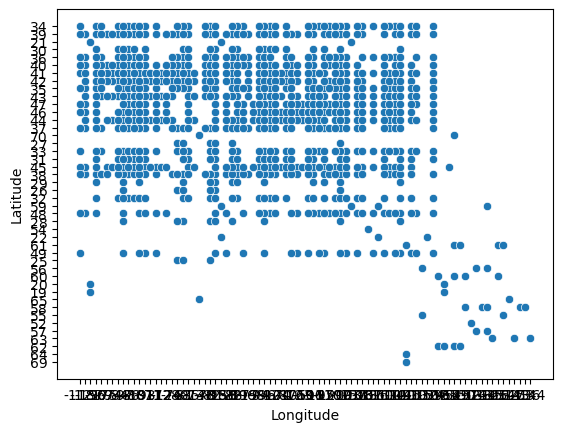

In [12]:
sns.scatterplot(x='Longitude', y='Latitude', data=igate_cl, alpha=1)

In [13]:
import fiona
import geopandas as gp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import collections
from shapely.geometry import LineString, Point

<AxesSubplot:>

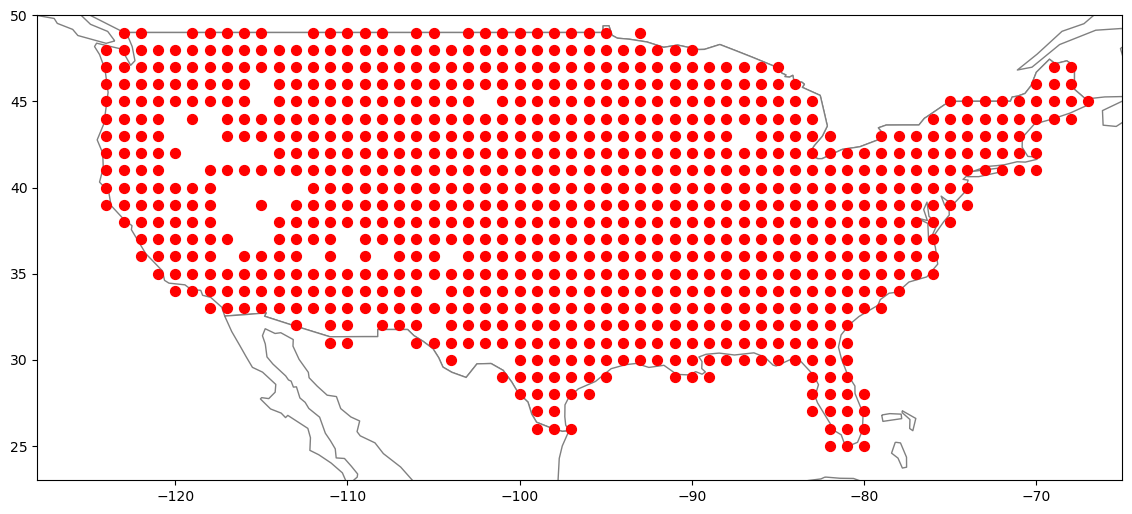

In [14]:
# Plot base map
world = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = world.plot(color="white", edgecolor="0.5", figsize=(14, 7))
ax.set_ylim([23, 50])
ax.set_xlim([-128, -65])

# Draw destination points
points = gp.points_from_xy(
    igate_cl["Longitude"],
    igate_cl["Latitude"],
)
gp.GeoDataFrame(igate_cl, geometry=points).plot(ax=ax, color="red", markersize=50, alpha=1)
# plt.savefig(f"candidate_locations_sites.pdf", dpi=300);
# plt.savefig(f"candidate_locations_sites.png", dpi=300);

#### 3.4.3. Filter by NAICS

Filter locations by more relevant North American Industry Classification System ([NAICS](https://www.census.gov/naics/)). These are:
- 325 Chemical Manufacturing
- 327 Nonmetallic Mineral Product Manufacturing
- 331 Primary Metal Manufacturing
- 332 Fabricated Metal Product Manufacturing
- 334 Computer and Electronic Product Manufacturing
- 335 Electrical Equipment, Appliance, and Component Manufacturing
- 339 Miscellaneous Manufacturing

In [15]:
naics_selection = ['325_', '327_', '331_','332_', '334_', '335_', '339_']

In [16]:
mask1=igate_cl['Naics_3digit'].str.contains('|'.join(naics_selection),regex=True)

In [17]:
igate_cl_naics_filtered = igate_cl.loc[mask1]

In [18]:
print('There are now {} locations'.format(len(igate_cl_naics_filtered)))

There are now 309 locations


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

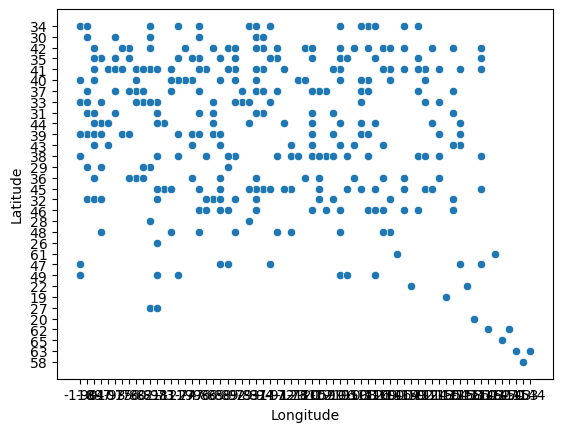

In [19]:
sns.scatterplot(x='Longitude', y='Latitude', data=igate_cl_naics_filtered, alpha=1)

<AxesSubplot:>

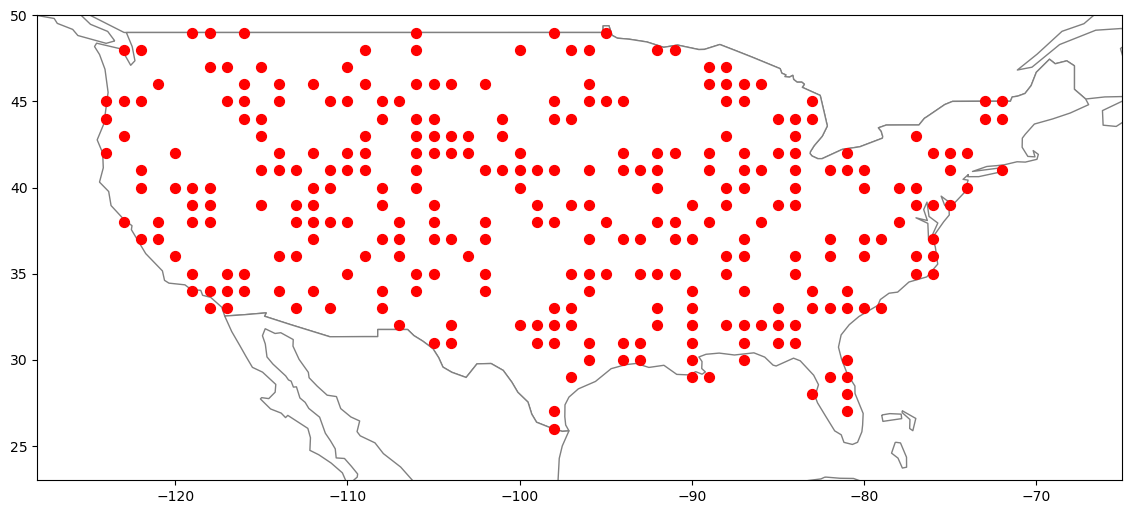

In [20]:
# Plot base map
world = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = world.plot(color="white", edgecolor="0.5", figsize=(14, 7))
ax.set_ylim([23, 50])
ax.set_xlim([-128, -65])

# Draw destination points
points = gp.points_from_xy(
    igate_cl_naics_filtered["Longitude"],
    igate_cl_naics_filtered["Latitude"],
)
gp.GeoDataFrame(igate_cl_naics_filtered, geometry=points).plot(ax=ax, color="red", markersize=50, alpha=1)
# plt.savefig(f"candidate_locations_sites.pdf", dpi=300);
# plt.savefig(f"candidate_locations_sites.png", dpi=300);

#### 3.4.4. Convert into RELOG Candidate Locations formats and save

Let's clean both datasets `igate_cl_naics` and `igate_cl_naics_filtered` and make the unique names column, with the `initial capacity (tonne)`, `area cost factor` columns.

In [21]:
igate_cl_output = igate_cl.drop(['Address', 'Naics_3digit', 'latlong', 'geometry'], axis=1)
igate_cl_naics_filtered_output = igate_cl_naics_filtered.drop(['Address', 'Naics_3digit', 'latlong', 'geometry'], axis=1)

In [22]:
igate_cl_output = igate_cl_output.rename(columns={'Latitude': 'latitude (deg)', 'Longitude': 'longitude (deg)', 'Name':'name'})
igate_cl_naics_filtered_output = igate_cl_naics_filtered_output.rename(columns={'Latitude': 'latitude (deg)', 'Longitude': 'longitude (deg)', 'Name':'name'})

In [23]:
igate_cl_output['name'] = igate_cl_output['name'] + ', ' + igate_cl_output['State']
igate_cl_naics_filtered_output['name'] = igate_cl_naics_filtered_output['name']+ ', ' + igate_cl_naics_filtered_output['State']

In [24]:
print('There are {} unique names in the duplicates filtered data.'.format(len(igate_cl_output['name'])))
print('There are {} unique names in the duplicates and naics filtered data.'.format(len(igate_cl_naics_filtered_output['name'])))

There are 914 unique names in the duplicates filtered data.
There are 309 unique names in the duplicates and naics filtered data.


In [25]:
igate_cl_output = igate_cl_output.reindex(columns=['name', 'latitude (deg)', 'longitude (deg)', 'State','initial capacity (tonne)','area cost factor'], fill_value=0)
igate_cl_naics_filtered_output = igate_cl_naics_filtered_output.reindex(columns=['name', 'latitude (deg)', 'longitude (deg)', 'State','initial capacity (tonne)','area cost factor'], fill_value=0)

#### 3.4.5. Map Area cost factors with the DOD csv.

In [26]:
cwd = os.getcwd()
area_cost_factors = pd.read_csv(os.path.join(cwd, 'miscellaneous', 'dod_area_cost_factors.csv'))

In [27]:
area_cost_dict = dict(zip(area_cost_factors['State Code'], area_cost_factors['ACF Official']))

In [28]:
igate_cl_output["area cost factor"] = igate_cl_output["State"].apply(lambda x: area_cost_dict.get(x))
igate_cl_naics_filtered_output["area cost factor"] = igate_cl_naics_filtered_output["State"].apply(lambda x: area_cost_dict.get(x))

Now let's set it so it is relative to Ohio!

In [29]:
igate_cl_output['area cost factor'] = igate_cl_output['area cost factor']/area_cost_dict['OH']
igate_cl_naics_filtered_output['area cost factor'] = igate_cl_naics_filtered_output['area cost factor']/area_cost_dict['OH']

In [30]:
igate_cl_output = igate_cl_output.drop('State', axis=1)
igate_cl_naics_filtered_output = igate_cl_naics_filtered_output.drop('State', axis=1)

In [31]:
igate_cl_output.to_csv(os.path.join(cwd, 'RELOG_import_data', 'CandidateLocations', 'cl_igate_single_loc.csv'), index=False)
igate_cl_naics_filtered_output.to_csv(os.path.join(cwd, 'RELOG_import_data', 'CandidateLocations', 'cl_igate_single_loc_filter_naics.csv'), index=False)

### 3.5. Energy Communities

These candidate locations can be downloaded from [Datasets for IWG Report on Energy Communities](https://edx.netl.doe.gov/dataset/datasets-for-iwg-report-on-energy-communities) based on the Initial Report to the
President on Empowering Workers Through Revitalizing Energy Communities. These locations are communities that fall under the BIL 40209, from the Infrastructure Investment and Jobs Act, Public Law 117-58. Provides technical assistance and grants to small- and medium-sized manufacturers in coal communities, the program is called [Advanced Energy Manufacturing and Recycling Grant Program](https://www.energy.gov/mesc/advanced-energy-manufacturing-and-recycling-grants).

The file I use is inside `iwg_energycommunitiesdatasets_csv_april2021.zip` and it is the file `RETIREDPowerPlants_wCoalGen_btwn2005_2020.csv`.

#### 3.5.1. Load and preliminary cleanup

In [2]:
cwd = os.getcwd()

In [3]:
ret_plants_40209 = pd.read_csv(os.path.join('CandidateLocations_RAW', 'RETIREDPowerPlants_wCoalGen_btwn2005_2020.csv'))

NOTE: `CandidateLocations_RAW` is not a public folder, if you wish to get access to the contents of this file, please contact hope.wikoff@nrel.gov.

In [194]:
ret_plants_40209_cl = ret_plants_40209.copy()

In [195]:
print('There are {} locations.'.format(len(ret_plants_40209_cl)))

There are 722 locations.


Let's get rid of the columns we don't need:

In [196]:
ret_plants_40209_cl.columns

Index(['OID_', 'Entity_ID', 'Plant_Name', 'Nameplate_Capacity__MW_',
       'Technology', 'Operating_Year', 'Retirement_Year', 'County_GEOID',
       'County Name', 'State', 'State code'],
      dtype='object')

In [197]:
columns_to_drop = ['OID_', 'Entity_ID', 'Nameplate_Capacity__MW_', 'Technology', 'Operating_Year', 'Retirement_Year', 'County Name', 'State code']

In [198]:
ret_plants_40209_cl.drop(columns_to_drop, axis=1, inplace= True)

In [199]:
ret_plants_40209_cl['State'].unique()

array(['Arizona', 'Illinois', 'Michigan', 'Washington', 'Florida',
       'New Mexico', 'Alabama', 'Oregon', 'Texas', 'Maryland', 'Ohio',
       'Kentucky', 'Missouri', 'New York', 'Pennsylvania',
       'North Carolina', 'Montana', 'West Virginia', 'Utah', 'Colorado',
       'Georgia', 'Virginia', 'New Jersey', 'Minnesota', 'Mississippi',
       'Kansas', 'Wisconsin', 'Indiana', 'Tennessee', 'Massachusetts',
       'Nevada', 'North Dakota', 'Iowa', 'Oklahoma', 'California',
       'South Carolina', 'South Dakota', 'Wyoming', 'Delaware', 'Alaska',
       nan], dtype=object)

Let's remove Alaska:

In [200]:
ret_plants_40209_cl = ret_plants_40209_cl[ret_plants_40209_cl['State'] != 'Alaska']

Now let's get rid of NaN values:

In [201]:
ret_plants_40209_cl.isna().sum()

Plant_Name      0
County_GEOID    1
State           1
dtype: int64

In [202]:
print('There are {} locations.'.format(len(ret_plants_40209_cl)))

There are 720 locations.


In [203]:
ret_plants_40209_cl = ret_plants_40209_cl.drop(labels=ret_plants_40209_cl[ret_plants_40209_cl['County_GEOID'].isna()].index)

In [204]:
ret_plants_40209_cl.isna().sum()

Plant_Name      0
County_GEOID    0
State           0
dtype: int64

Make the GEOID's as int.

In [205]:
ret_plants_40209_cl['County_GEOID']=ret_plants_40209_cl['County_GEOID'].astype('int')

Drop duplicates.

In [206]:
ret_plants_40209_cl.drop_duplicates(subset='County_GEOID', inplace=True)

In [207]:
print('There are {} locations.'.format(len(ret_plants_40209_cl)))

There are 268 locations.


#### 3.5.2. Setup the dataframe with the collection center format and map to get lat and long

Rename the columns and create new ones so they are in the RELOG Candidate Locations format. I will leave the `County_GEOID` and `State` columns because I need them for the mapping to get latitudes and longitudes, and the cost area factors, respectively. I will drop these two afterwards before saving the dataframe.

In [208]:
ret_plants_40209_cl.rename(columns = {'Plant_Name':'name'}, inplace=True)

In [209]:
ret_plants_40209_cl['name'] = ret_plants_40209_cl['name'] + ', ' + ret_plants_40209_cl['State']

In [210]:
ret_plants_40209_cl.head()

,name,County_GEOID,State
0,"Cholla, Arizona",4017,Arizona
1,"Dallman, Illinois",17167,Illinois
3,"Eckert Station, Michigan",26065,Michigan
5,"Transalta Centralia Generation, Washington",53041,Washington
6,"Indiantown Cogeneration LP, Florida",12085,Florida


In [211]:
ret_plants_40209_cl = ret_plants_40209_cl.reindex(columns=['name', 'County_GEOID', 'State', 'latitude (deg)', 'longitude (deg)','initial capacity (tonne)','area cost factor'], fill_value=0)
ret_plants_40209_cl.head()

,name,County_GEOID,State,latitude (deg),longitude (deg),initial capacity (tonne),area cost factor
0,"Cholla, Arizona",4017,Arizona,0,0,0,0
1,"Dallman, Illinois",17167,Illinois,0,0,0,0
3,"Eckert Station, Michigan",26065,Michigan,0,0,0,0
5,"Transalta Centralia Generation, Washington",53041,Washington,0,0,0,0
6,"Indiantown Cogeneration LP, Florida",12085,Florida,0,0,0,0


Now let's correlate the GEOID's/FIPS with latitude and longitude. This is more tricky, I have done it the other way around (get FIPS from latitude and longitude values). The following data come from [this](https://github.com/josh-byster/fips_lat_long) repository, `counties.txt` contains GEOID's or FIPS codes and their corresponding latitude and longitude, which I can map with my dataframe. Original data provided by the [U.S. Census Gazetteer Files](https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.html). 

In [212]:
counties = pd.read_csv(os.path.join(cwd, 'miscellaneous', 'counties.txt'), sep="\t")

In [213]:
counties.head()

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,1001,161526,Autauga County,1539602137,25706961,594.444,9.926,32.532237,-86.646440
1,AL,1003,161527,Baldwin County,4117621645,1132980868,1589.823,437.446,30.659218,-87.746067
2,AL,1005,161528,Barbour County,2292160139,50523213,885.008,19.507,31.870253,-85.405104
3,AL,1007,161529,Bibb County,1612167476,9602089,622.461,3.707,33.015893,-87.127148
4,AL,1009,161530,Blount County,1670103866,15015467,644.831,5.798,33.977358,-86.566440


In [214]:
counties.keys()

Index(['USPS', 'GEOID', 'ANSICODE', 'NAME', 'ALAND', 'AWATER', 'ALAND_SQMI',
       'AWATER_SQMI', 'INTPTLAT',
       'INTPTLONG                                                                                                               '],
      dtype='object')

The column `INTPLONG` has a lot of white spaces so it does not recognize it as a key. I fix it:

In [215]:
counties.rename(columns = {'INTPTLONG                                                                                                               ':'INTPTLONG'}, inplace=True)

In [216]:
counties.keys()

Index(['USPS', 'GEOID', 'ANSICODE', 'NAME', 'ALAND', 'AWATER', 'ALAND_SQMI',
       'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG'],
      dtype='object')

In [219]:
ret_plants_40209_cl['latitude (deg)'] = ret_plants_40209_cl['County_GEOID'].map(counties.set_index('GEOID')['INTPTLAT'])
ret_plants_40209_cl['longitude (deg)'] = ret_plants_40209_cl['County_GEOID'].map(counties.set_index('GEOID')['INTPTLONG'])

In [220]:
ret_plants_40209_cl

,name,County_GEOID,State,latitude (deg),longitude (deg),initial capacity (tonne),area cost factor
0,"Cholla, Arizona",4017,Arizona,35.390785,-110.321025,0,0
1,"Dallman, Illinois",17167,Illinois,39.756867,-89.662425,0,0
3,"Eckert Station, Michigan",26065,Michigan,42.603534,-84.373811,0,0
5,"Transalta Centralia Generation, Washington",53041,Washington,46.580071,-122.377444,0,0
6,"Indiantown Cogeneration LP, Florida",12085,Florida,27.083604,-80.398201,0,0
...,...,...,...,...,...,...,...
705,"Dan River Power Plant, Virginia",51590,Virginia,36.583334,-79.408071,0,0
709,"Hoot Lake, Minnesota",27111,Minnesota,46.405727,-95.714581,0,0
712,"Lowland, Tennessee",47063,Tennessee,36.218397,-83.266071,0,0
717,"Washington State University, Washington",53075,Washington,46.905944,-117.535390,0,0


#### 3.5.3. Map area factors and save!

In [5]:
cwd = os.getcwd()
area_cost_factors = pd.read_csv(os.path.join(cwd, 'miscellaneous', 'dod_area_cost_factors.csv'))

In [222]:
ret_plants_40209_cl['area cost factor'] = ret_plants_40209_cl['State'].map(area_cost_factors.set_index('State')['ACF Official'])

In [223]:
ret_plants_40209_cl.head()

,name,County_GEOID,State,latitude (deg),longitude (deg),initial capacity (tonne),area cost factor
0,"Cholla, Arizona",4017,Arizona,35.390785,-110.321025,0,0.85
1,"Dallman, Illinois",17167,Illinois,39.756867,-89.662425,0,1.07
3,"Eckert Station, Michigan",26065,Michigan,42.603534,-84.373811,0,0.99
5,"Transalta Centralia Generation, Washington",53041,Washington,46.580071,-122.377444,0,1.11
6,"Indiantown Cogeneration LP, Florida",12085,Florida,27.083604,-80.398201,0,0.86


Now let's set it so it is relative to Ohio! To change it to a different state just type the name of the state of interest and change the pertinent index.

In [10]:
area_cost_factors[area_cost_factors['State'] == 'Ohio'].index # Check the index where Ohio is found, there is probably a smarter way...

Int64Index([35], dtype='int64')

For Ohio is 35, so I write that number, now it will be a different one for other cases so remember to change the state name and INDEX NUMBER in the following **two** cells.

In [224]:
area_cost_factors[area_cost_factors['State'] == 'Ohio']['ACF Official'][35] # this is the index where Ohio is found

0.94

In [225]:
ret_plants_40209_cl['area cost factor'] = ret_plants_40209_cl['area cost factor']/area_cost_factors[area_cost_factors['State'] == 'Ohio']['ACF Official'][35]


In [226]:
ret_plants_40209_cl

,name,County_GEOID,State,latitude (deg),longitude (deg),initial capacity (tonne),area cost factor
0,"Cholla, Arizona",4017,Arizona,35.390785,-110.321025,0,0.904255
1,"Dallman, Illinois",17167,Illinois,39.756867,-89.662425,0,1.138298
3,"Eckert Station, Michigan",26065,Michigan,42.603534,-84.373811,0,1.053191
5,"Transalta Centralia Generation, Washington",53041,Washington,46.580071,-122.377444,0,1.180851
6,"Indiantown Cogeneration LP, Florida",12085,Florida,27.083604,-80.398201,0,0.914894
...,...,...,...,...,...,...,...
705,"Dan River Power Plant, Virginia",51590,Virginia,36.583334,-79.408071,0,0.872340
709,"Hoot Lake, Minnesota",27111,Minnesota,46.405727,-95.714581,0,1.159574
712,"Lowland, Tennessee",47063,Tennessee,36.218397,-83.266071,0,0.914894
717,"Washington State University, Washington",53075,Washington,46.905944,-117.535390,0,1.180851


Let's drop the unnecessary columns, i.e. `County_GEOID` and `State`.

In [228]:
ret_plants_40209_cl = ret_plants_40209_cl.drop(['County_GEOID', 'State'], axis=1)

In [230]:
ret_plants_40209_cl.head()

,name,latitude (deg),longitude (deg),initial capacity (tonne),area cost factor
0,"Cholla, Arizona",35.390785,-110.321025,0,0.904255
1,"Dallman, Illinois",39.756867,-89.662425,0,1.138298
3,"Eckert Station, Michigan",42.603534,-84.373811,0,1.053191
5,"Transalta Centralia Generation, Washington",46.580071,-122.377444,0,1.180851
6,"Indiantown Cogeneration LP, Florida",27.083604,-80.398201,0,0.914894


Save and done!

In [231]:
ret_plants_40209_cl.to_csv(os.path.join(cwd, 'RELOG_import_data', 'CandidateLocations', 'cl_40209_retired_plants.csv'), index=False)


## 4. Go to RELOG case-builder

Now you know how to generate the two files needed as inputs for RELOG. Go to RELOG web-based [case builder](https://relog.axavier.org/casebuilder) to setup the .json simulation file. For this baseline scenario I have used the files [pv_Modules_ia.csv](PV_Recycling_Plant/data/RELOG_import_data/Ordered/pv_Modules_ia.csv) as **collection center inputs** and [CandidateLocations_CA](PV_Recycling_Plant/data/RELOG_import_data/CandidateLocations_CA.csv) and **candidate locations**.

Remember that to be able to run a proper simulation you need to make sure that:
* The PV_ICE output files have the same studied years than the one set in the case-builder. In this example we have 28 years.
* You know the recycling plant's efficiencies (i.e. how much material is recovered per tonne processed).
* You have the capacity and cost data of your plant.



---
## 5. Sankey Diagram

For the Sankey Diagram, I need:
1) Get the waste (cSi + CdTe).
    * Get the cSi waste and CdTe waste.
    * Get the amount of each material in cSi and CdTe.
2) Add all those materials into material bins.
3) Pass them by an intermediate bin with the recycling process an d  their recycling yield.
4) Add all those materials and check how much of each could contribute to revenue based on their value.

**Note:** To visualize the Sankey diagram in Jupyter, you may need to add the plotly extension, you can install it by running this line in the terminal: `jupyter labextension install plotlywidget`. [Source]().

### 5.0. Load the waste files if you haven't run the previous cells

In [ ]:
# Uncomment if you need this option

csi_Module = pd.read_csv('csi_wasteEOL_Module.csv')
csi_aluminium_frames = pd.read_csv('csi_wasteEOL_aluminium_frames.csv')
csi_backsheet = pd.read_csv('csi_wasteEOL_backsheet.csv')
csi_copper = pd.read_csv('csi_wasteEOL_copper.csv')
csi_encapsulant = pd.read_csv('csi_wasteEOL_encapsulant.csv')
csi_glass = pd.read_csv('csi_wasteEOL_glass.csv')
csi_silicon = pd.read_csv('csi_wasteEOL_silicon.csv')
csi_silver = pd.read_csv('csi_wasteEOL_silver.csv')



cdte_Module = pd.read_csv('cdte_wasteEOL_Module.csv')
cdte_aluminium_frames_cdte = pd.read_csv('cdte_wasteEOL_aluminium_frames_cdte.csv')
cdte_cadmium = pd.read_csv('cdte_wasteEOL_cadmium.csv')
cdte_copper_cdte = pd.read_csv('cdte_wasteEOL_copper_cdte.csv')
cdte_encapsulant_cdte = pd.read_csv('cdte_wasteEOL_encapsulant_cdte.csv')
cdte_glass_cdte = pd.read_csv('cdte_wasteEOL_glass_cdte.csv')
cdte_tellurium = pd.read_csv('cdte_wasteEOL_tellurium.csv')

### 5.1. Get all waste

In [ ]:
csi_waste = csi_Module['total waste'].sum()
cdte_waste = cdte_Module['total waste'].sum()
all_waste = csi_waste + cdte_waste
print(f'There are {all_waste:.2f} tonnes of PV waste (that\'s {all_waste/1000000:.2f} million metric tonnes).')
print(f'There are {csi_waste:.2f} tonnes of cSi, and {cdte_waste:.2f} tonnes of CdTe.')
perc_csi = csi_waste/all_waste
perc_cdte = cdte_waste/all_waste
print(f'Of all the waste, {perc_csi*100:.2f}% is cSi, and {perc_cdte*100:.2f}% is CdTe.')

In [ ]:
# Option for one year, just change the year to the one you need

csi_waste_2050 = csi_Module['2050'].sum()
cdte_waste_2050 = cdte_Module['2050'].sum()
all_waste_2050 = csi_waste_2050 + cdte_waste_2050
print(f'There are {all_waste_2050:.2f} tonnes of PV waste (that\'s {all_waste_2050/1000000:.2f} million metric tonnes).')
print(f'There are {csi_waste_2050:.2f} tonnes of cSi, and {cdte_waste_2050:.2f} tonnes of CdTe.')
perc_csi_2050 = csi_waste_2050/all_waste_2050
perc_cdte_2050 = cdte_waste_2050/all_waste_2050
print(f'Of all the waste, {perc_csi_2050*100:.2f}% is cSi, and {perc_cdte_2050*100:.2f}% is CdTe.')

### 5.2. Waste material bins

#### 5.2.1. cSi

In [ ]:
csi_waste = {'Modules' : csi_Module['total waste'].sum(),
            'Glass' : csi_glass['total waste'].sum(),
            'Silicon' : csi_silicon['total waste'].sum(),
            'Silver': csi_silver['total waste'].sum(),
            'Copper' : csi_copper['total waste'].sum(),
            'Aluminium frames': csi_aluminium_frames['total waste'].sum(),
            'Encapsulant': csi_encapsulant['total waste'].sum(),
            'Backsheet': csi_backsheet['total waste'].sum(),}

In [ ]:

csi_waste_2050 = {'Modules' : csi_Module['2050'].sum(),
            'Glass' : csi_glass['2050'].sum(),
            'Silicon' : csi_silicon['2050'].sum(),
            'Silver': csi_silver['2050'].sum(),
            'Copper' : csi_copper['2050'].sum(),
            'Aluminium frames': csi_aluminium_frames['2050'].sum(),
            'Encapsulant': csi_encapsulant['2050'].sum(),
            'Backsheet': csi_backsheet['2050'].sum(),}

#### 5.2.2. CdTe

In [ ]:
cdte_waste = {'Modules' : cdte_Module['total waste'].sum(),
            'Glass' : cdte_glass_cdte['total waste'].sum(),
            'Cadmium': cdte_cadmium['total waste'].sum(),
            'Tellurium': cdte_tellurium['total waste'].sum(),
            'Copper' : cdte_copper_cdte['total waste'].sum(), # No data about the copper recovery, so I assume the same as FRELP
            'Aluminium frames': cdte_aluminium_frames_cdte['total waste'].sum(),
            'Encapsulant': cdte_encapsulant_cdte['total waste'].sum(),} # Here there is no info so I assume the same as the glass

In [ ]:
# Option for one year, just change the year to the one you need

cdte_waste_2050 = {'Modules' : cdte_Module['2050'].sum(),
            'Glass' : cdte_glass_cdte['2050'].sum(),
            'Cadmium': cdte_cadmium['2050'].sum(),
            'Tellurium': cdte_tellurium['2050'].sum(),
            'Copper' : cdte_copper_cdte['2050'].sum(), # No data about the copper recovery, so I assume the same as FRELP
            'Aluminium frames': cdte_aluminium_frames_cdte['2050'].sum(),
            'Encapsulant': cdte_encapsulant_cdte['2050'].sum(),} # Here there is no info so I assume the same as the glass


### 5.3. Recycling bins <a id='#Section4.3'></a>

#### 5.3.1. cSi

In [ ]:
#FRELP efficiencies unless indicated

csi_recycled = {'Modules' : csi_Module['total waste'].sum(),
            'Glass' : csi_glass['total waste'].sum()*0.98, 
            'Silicon' : csi_silicon['total waste'].sum()*0.95,
            'Silver': csi_silver['total waste'].sum()*0.95,
            'Copper' : csi_copper['total waste'].sum()*0.95,
            'Aluminium frames': csi_aluminium_frames['total waste'].sum(), # Assume 100% from the frames
            'Encapsulant': csi_encapsulant['total waste'].sum(), # Here the encapsulant is incinerated so, 100% goes out
            'Backsheet': csi_backsheet['total waste'].sum(),# Same as encapsulant
            'Landfill': csi_glass['total waste'].sum()*(1-0.98) + 
                csi_silicon['total waste'].sum()*(1-0.95) + 
                csi_silver['total waste'].sum()*(1-0.95) + 
                csi_copper['total waste'].sum()*(1-0.95),
            'Energy': csi_encapsulant['total waste'].sum()+csi_backsheet['total waste'].sum()} # Amount of waste that is burned and returned as energy 

In [ ]:
# Option for one year, just change the year to the one you need

csi_recycled_2050 = {'Modules' : csi_Module['2050'].sum(),
            'Glass' : csi_glass['2050'].sum()*0.98, 
            'Silicon' : csi_silicon['2050'].sum()*0.95,
            'Silver': csi_silver['2050'].sum()*0.95,
            'Copper' : csi_copper['2050'].sum()*0.95,
            'Aluminium frames': csi_aluminium_frames['2050'].sum(), # Assume 100% from the frames
            'Encapsulant': csi_encapsulant['2050'].sum(), # Here the encapsulant is incinerated so, 100% goes out
            'Backsheet': csi_backsheet['2050'].sum(),# Same as encapsulant
            'Landfill': csi_glass['2050'].sum()*(1-0.98) + 
                csi_silicon['2050'].sum()*(1-0.95) + 
                csi_silver['2050'].sum()*(1-0.95) + 
                csi_copper['2050'].sum()*(1-0.95),
            'Energy': csi_encapsulant['2050'].sum()+csi_backsheet['2050'].sum()} 

#### 5.3.2. CdTe

In [ ]:
# First Solar efficiencies unless indicated

cdte_recycled = {'Modules' : cdte_Module['total waste'].sum(),
            'Glass' : cdte_glass_cdte['total waste'].sum()*0.9,
            'Cadmium': cdte_cadmium['total waste'].sum()*0.95,
            'Tellurium': cdte_tellurium['total waste'].sum()*0.95,
            'Copper' : cdte_copper_cdte['total waste'].sum()*0.95, # No data about the copper recovery, so I assume the same as FRELP
            'Aluminium frames': cdte_aluminium_frames_cdte['total waste'].sum(),
            'Encapsulant': cdte_encapsulant_cdte['total waste'].sum()*0.9,# Here there is no info so I assume the same as the glass
            'Landfill':cdte_glass_cdte['total waste'].sum()*(1-0.9) +
                cdte_cadmium['total waste'].sum()*(1-0.95) +
                cdte_tellurium['total waste'].sum()*(1-0.95) +
                cdte_copper_cdte['total waste'].sum()*(1-0.95) +
                cdte_encapsulant_cdte['total waste'].sum()*(1-0.9),
            } 

In [ ]:
# Option for one year, just change the year to the one you need

cdte_recycled_2050 = {'Modules' : cdte_Module['2050'].sum(),
            'Glass' : cdte_glass_cdte['2050'].sum()*0.9,
            'Cadmium': cdte_cadmium['2050'].sum()*0.95,
            'Tellurium': cdte_tellurium['2050'].sum()*0.95,
            'Copper' : cdte_copper_cdte['2050'].sum()*0.95, # No data about the copper recovery, so I assume the same as FRELP
            'Aluminium frames': cdte_aluminium_frames_cdte['2050'].sum(),
            'Encapsulant': cdte_encapsulant_cdte['2050'].sum()*0.9,# Here there is no info so I assume the same as the glass
            'Landfill':cdte_glass_cdte['2050'].sum()*(1-0.9) +
                cdte_cadmium['2050'].sum()*(1-0.95) +
                cdte_tellurium['2050'].sum()*(1-0.95) +
                cdte_copper_cdte['2050'].sum()*(1-0.95) +
                cdte_encapsulant_cdte['2050'].sum()*(1-0.9),
            } 

### 4.4. Generate figures

In [ ]:
import plotly.graph_objects as go

In [ ]:
if not os.path.exists("images"):
    os.mkdir("images")

In [ ]:
my_colors = {'pvwaste':'rgba(255, 243, 217, 1)',
             'csi_blue': 'rgba(199, 219, 244,1)',
             'cdte_tiel': 'rgba(215, 250, 245, 1)',
             'product_green': 'rgba(217, 240, 217, 1)',
             'energy_yellow': 'rgba(252, 252, 202, 1)',
             'waste_red': 'rgba(247, 145, 116,1)',
             'worth_green': 'rgba(192, 232, 131,1)'}

In [ ]:
material_list_csi = ['glass', 'silicon', 'silver', 'copper', 'aluminium_frames', 'encapsulant', 'backsheet', 'Module']
material_list_cdte = ['cadmium', 'telluride', 'glass_cdte', 'aluminium_frames_cdte', 'Module', 'copper_cdte', 'encapsulant_cdte']

#### 5.4.1. Sankey Option 1 - Labeled

In [ ]:
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(color = 'black', width = 0.5),
      label = ['PV Waste', 'cSi', 'CdTe', 
               'Glass', 'Silicon', 'Silver', 'Copper', 'Aluminum frames', 'Encapsulant', 'Backsheet', 
               'Glass', 'Cadmium', 'Tellurium', 'Copper', 'Aluminum frames', 'Encapsulant', 
               'cSi Recycling', 'CdTe Recycling', 
               'Glass scrap', 'Manufacturing grade silicon', 'Copper scrap', 'Silver scrap', 'Cadmium scrap', 'Tellurium scrap', 'Aluminum scrap', 'Landfill', 'Energy'],
      color = [my_colors['pvwaste'], my_colors['csi_blue'], my_colors['cdte_tiel'], 
               my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], 
               my_colors['cdte_tiel'],my_colors['cdte_tiel'],my_colors['cdte_tiel'],my_colors['cdte_tiel'],my_colors['cdte_tiel'],my_colors['cdte_tiel'], 
               my_colors['csi_blue'], my_colors['cdte_tiel'], 
               my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['waste_red'], my_colors['worth_green']]
),
    link = dict(
      source = [0, 0, 
                1, 1, 1, 1, 1, 1, 1, 
                2, 2, 2, 2, 2, 2, 
                3, 4, 5, 6, 7, 8, 9,
                10, 11, 12, 13, 14, 15,
                16,16,16,16,16,16,16,
                17,17,17,17,17,17, ], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [1, 2, 
                3, 4, 5, 6, 7, 8, 9, 
                10, 11, 12, 13, 14, 15,
                16, 16, 16, 16, 16, 16, 16,
                17, 17, 17, 17, 17, 17,
                18, 19, 20, 21, 24, 25, 26,
                18, 20, 22, 23, 24, 25],
      value = [csi_waste['Modules'], cdte_waste['Modules'], 
               csi_waste['Glass'], csi_waste['Silicon'], csi_waste['Silver'], csi_waste['Copper'], csi_waste['Aluminium frames'], csi_waste['Encapsulant'], csi_waste['Backsheet'], 
               cdte_waste['Glass'], cdte_waste['Cadmium'], cdte_waste['Tellurium'], cdte_waste['Copper'], cdte_waste['Aluminium frames'], cdte_waste['Encapsulant'],
               csi_waste['Glass'], csi_waste['Silicon'], csi_waste['Silver'], csi_waste['Copper'], csi_waste['Aluminium frames'], csi_waste['Encapsulant'], csi_waste['Backsheet'], 
               cdte_waste['Glass'], cdte_waste['Cadmium'], cdte_waste['Tellurium'], cdte_waste['Copper'], cdte_waste['Aluminium frames'], cdte_waste['Encapsulant'],
               csi_recycled['Glass'], csi_recycled['Silicon'], csi_recycled['Copper'], csi_recycled['Silver'], csi_recycled['Aluminium frames'], csi_recycled['Landfill'],csi_recycled['Energy'],
               cdte_recycled['Glass'], cdte_recycled['Copper'], cdte_recycled['Cadmium'], cdte_recycled['Tellurium'], cdte_recycled['Aluminium frames'], cdte_recycled['Landfill']],
      color = 'rgba(240, 240, 245, 0.65)'
  ))])

fig.update_layout(font_family="Times New Roman", font_size=10)
fig.write_image("images/sankey/sankey_labeled.svg")

#### 5.4.2. Sankey Option 2 - Labeled simplified

In [ ]:
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(color = 'black', width = 0.5),
      label = ['PV Waste', 'cSi Recycling', 'CdTe Recycling', 
               'Glass scrap', 'Manufacturing grade silicon', 'Copper scrap', 'Silver scrap', 'Cadmium scrap', 'Tellurium scrap', 'Aluminum scrap', 'Landfill', 'Energy'],
      color = [my_colors['pvwaste'], my_colors['csi_blue'], my_colors['cdte_tiel'], 
               my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['waste_red'], my_colors['worth_green']]
),
    link = dict(
      source = [0, 0, 
                1,1,1,1,1,1,1,
                2,2,2,2,2,2, ], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [1, 2,
                3, 4, 5, 6, 9, 10, 11,
                3, 5, 7, 8, 9, 10],
      value = [csi_waste['Modules'], cdte_waste['Modules'], 
               csi_recycled['Glass'], csi_recycled['Silicon'], csi_recycled['Copper'], csi_recycled['Silver'], csi_recycled['Aluminium frames'], csi_recycled['Landfill'],csi_recycled['Energy'],
               cdte_recycled['Glass'], cdte_recycled['Copper'], cdte_recycled['Cadmium'], cdte_recycled['Tellurium'], cdte_recycled['Aluminium frames'], cdte_recycled['Landfill']],
      color = 'rgba(240, 240, 245, 0.65)'
  ))])

fig.update_layout(font_family="Times New Roman", font_size=10)
fig.write_image("images/sankey/sankey_labeled_simplified.svg")

#### 5.4.3. Sankey Option 3 - Muted

In [ ]:
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(color = 'black', width = 0.5),
      label = ['', '', '', 
               '', '', '', '', '', '', '', 
               '', '', '', '', '', '', 
               '', '', 
               '', '', '', '', '', '', '', '', ''],
      color = [my_colors['pvwaste'], my_colors['csi_blue'], my_colors['cdte_tiel'], 
               my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], my_colors['csi_blue'], 
               my_colors['cdte_tiel'],my_colors['cdte_tiel'],my_colors['cdte_tiel'],my_colors['cdte_tiel'],my_colors['cdte_tiel'],my_colors['cdte_tiel'], 
               my_colors['csi_blue'], my_colors['cdte_tiel'], 
               my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['waste_red'], my_colors['worth_green']]
),
    link = dict(
      source = [0, 0, 
                1, 1, 1, 1, 1, 1, 1, 
                2, 2, 2, 2, 2, 2, 
                3, 4, 5, 6, 7, 8, 9,
                10, 11, 12, 13, 14, 15,
                16,16,16,16,16,16,16,
                17,17,17,17,17,17, ], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [1, 2, 
                3, 4, 5, 6, 7, 8, 9, 
                10, 11, 12, 13, 14, 15,
                16, 16, 16, 16, 16, 16, 16,
                17, 17, 17, 17, 17, 17,
                18, 19, 20, 21, 24, 25, 26,
                18, 20, 22, 23, 24, 25],
      value = [csi_waste['Modules'], cdte_waste['Modules'], 
               csi_waste['Glass'], csi_waste['Silicon'], csi_waste['Silver'], csi_waste['Copper'], csi_waste['Aluminium frames'], csi_waste['Encapsulant'], csi_waste['Backsheet'], 
               cdte_waste['Glass'], cdte_waste['Cadmium'], cdte_waste['Tellurium'], cdte_waste['Copper'], cdte_waste['Aluminium frames'], cdte_waste['Encapsulant'],
               csi_waste['Glass'], csi_waste['Silicon'], csi_waste['Silver'], csi_waste['Copper'], csi_waste['Aluminium frames'], csi_waste['Encapsulant'], csi_waste['Backsheet'], 
               cdte_waste['Glass'], cdte_waste['Cadmium'], cdte_waste['Tellurium'], cdte_waste['Copper'], cdte_waste['Aluminium frames'], cdte_waste['Encapsulant'],
               csi_recycled['Glass'], csi_recycled['Silicon'], csi_recycled['Copper'], csi_recycled['Silver'], csi_recycled['Aluminium frames'], csi_recycled['Landfill'],csi_recycled['Energy'],
               cdte_recycled['Glass'], cdte_recycled['Copper'], cdte_recycled['Cadmium'], cdte_recycled['Tellurium'], cdte_recycled['Aluminium frames'], cdte_recycled['Landfill']],
      color = 'rgba(240, 240, 245, 0.65)'
  ))])

fig.update_layout(font_family="Times New Roman", font_size=10)
fig.write_image("images/sankey/sankey_muted.svg")
#fig.write_image("images/sankey_mute.svg")

#### 5.4.4. Sankey Option 4 - Muted simplified

In [ ]:
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(color = 'black', width = 0.5),
      label = ['', '', '', 
               '', '', '', '', '', '', '', '', ''],
      color = [my_colors['pvwaste'], my_colors['csi_blue'], my_colors['cdte_tiel'], 
               my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['waste_red'], my_colors['worth_green']]
),
    link = dict(
      source = [0, 0, 
                1,1,1,1,1,1,1,
                2,2,2,2,2,2, ], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [1, 2,
                3, 4, 5, 6, 9, 10, 11,
                3, 5, 7, 8, 9, 10],
      value = [csi_waste['Modules'], cdte_waste['Modules'], 
               csi_recycled['Glass'], csi_recycled['Silicon'], csi_recycled['Copper'], csi_recycled['Silver'], csi_recycled['Aluminium frames'], csi_recycled['Landfill'],csi_recycled['Energy'],
               cdte_recycled['Glass'], cdte_recycled['Copper'], cdte_recycled['Cadmium'], cdte_recycled['Tellurium'], cdte_recycled['Aluminium frames'], cdte_recycled['Landfill']],
      color = 'rgba(240, 240, 245, 0.65)'
  ))])

fig.update_layout(font_family="Times New Roman", font_size=10)
fig.write_image("images/sankey/sankey_muted_simplified.svg")

In [ ]:
# Figure for one year 

fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(color = 'black', width = 0.5),
      label = ['', '', '', 
               '', '', '', '', '', '', '', '', ''],
      color = [my_colors['pvwaste'], my_colors['csi_blue'], my_colors['cdte_tiel'], 
               my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['product_green'], my_colors['waste_red'], my_colors['worth_green']],
      hovertemplate= 'Node value is %{value}'
    ),
    link = dict(
      source = [0, 0, 
                1,1,1,1,1,1,1,
                2,2,2,2,2,2, ], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [1, 2,
                3, 4, 5, 6, 9, 10, 11,
                3, 5, 7, 8, 9, 10],
      value = [csi_waste_2050['Modules'], cdte_waste_2050['Modules'], 
               csi_recycled_2050['Glass'], csi_recycled_2050['Silicon'], csi_recycled_2050['Copper'], csi_recycled_2050['Silver'], csi_recycled_2050['Aluminium frames'], csi_recycled_2050['Landfill'],csi_recycled_2050['Energy'],
               cdte_recycled_2050['Glass'], cdte_recycled_2050['Copper'], cdte_recycled_2050['Cadmium'], cdte_recycled_2050['Tellurium'], cdte_recycled_2050['Aluminium frames'], cdte_recycled_2050['Landfill']],
      color = 'rgba(240, 240, 245, 0.65)',
      hovertemplate= 'Link value is %{value}' 
  ))])

fig.update_layout(font_family="Times New Roman", font_size=10)
fig.write_image("images/sankey/sankey_muted_simplified_2050.png")
fig.show()

---
## 6. Cloropeth map option 1 (still under construction)

In [ ]:
pv_waste_map = csi_Module[['FIPS']].copy()
pv_waste_map['total waste'] = csi_Module['total waste'] + cdte_Module['total waste']
pv_waste_map.to_csv('images/cloropeth/pv_waste_map.csv')

csi_waste_map = csi_Module[['FIPS', 'total waste']]
csi_waste_map.to_csv('images/cloropeth/csi_waste_map.csv')

cdte_waste_map = cdte_Module[['FIPS', 'total waste']]
cdte_waste_map.to_csv('images/cloropeth/cdte_waste_map.csv')

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = pd.read_csv("images/cloropeth/pv_waste_map.csv",
                   dtype={"FIPS": str})

import plotly.express as px

fig = px.choropleth_mapbox(df, geojson=counties, locations='FIPS', color='total waste',
                           color_continuous_scale="Viridis",
                           range_color=(8, 1200000), # min an max values of waste
                           mapbox_style="carto-positron",
                           zoom=2.5, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'total waste':'Accumulated waste'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("images/cloropeth/map_allPV_op1.svg")

Cloropeth map option 2

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = pd.read_csv("pv_waste_map.csv",
                   dtype={"FIPS": str})

import plotly.express as px

fig = px.choropleth(df, geojson=counties, locations='FIPS', color='total waste',
                           color_continuous_scale="Viridis",
                           range_color=(1000, 50000),
                           scope="usa",
                           labels={'total waste':'Total PV waste by 2050'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("images/cloropeth/map_allPV_op2.svg")

In [ ]:
pv_waste_map.min()

In [ ]:
pv_waste_map.max()

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

import plotly.express as px

fig = px.choropleth(df, geojson=counties, locations='fips', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           scope="usa",
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("images/cloropeth/map_allPV_op2.svg")
